# Selecting C-type asteroids from the Gaia DR3 reflectance spectra with machine learning

Reproduce the initial classification by Joost Barendse of C-type vs non-C-type asteroid using ML algorithms.

The Gaia DR3 data was simply downloaded in full with the query:
```sql
select * from gaiadr3.sso_reflectance_spectrum
```
The reflectance spectra are corrected according to the prescriptions by [Tinaut-Ruano et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...669L..14T/abstract). The factors by which to multiply the `reflectance_spectrum` column are listed in their table 1.

| Wavelength (nm) | Correction Factor |
| -- | -- |
| 374.0 | 1.07 |
| 418.0 | 1.05 |
| 462.0 | 1.02 |
| 506.0 | 1.01 |

Additional data on the asteroids, their proper orbital elements, inverse diameters and magnitudes $H$, were downloaded from the [MP3C](https://mp3c.oca.eu/) database (on November 18 2023). An unconstrained "best values" search was done to get all data. These data are added to the table created with `create_sso_objects_file.py`. This was done by merging the tables in [topcat](https://www.star.bris.ac.uk/~mbt/topcat/) using the exact match on MPC numbers.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator  # used to get nice integer axis labels, see https://stackoverflow.com/a/34880501/12734641
import matplotlib.cm as cm
from astropy.visualization import HistEqStretch, ImageNormalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from astropy.table import Table

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score, completeness_score, homogeneity_score
from sklearn.cluster import KMeans

from scipy import stats

from tqdm import tqdm

import umap

from agabpylib.plotting.plotstyles import useagab, apply_tufte
from agabpylib.stats.robuststats import rse
from reflspectratools import (
    plot_spectra_collection,
    load_dr3_data,
    create_ml_training_classes,
    extract_spectra,
    prep_classifier_inputs,
)

useagab(fontsize=22, linewidths=3, axislinewidths=2)

## Read in the data
Read the Gaia DR3 data and the classified asteroid MPC numbers for use in ML classification training and application.

__NOTE__ that for the initial seperation of C-types from the rest of the asteroids the full range of wavelengths should be used for the spectra. That this is the case can be checked by re-running with `ssodata = load_dr3_data(clipspectra=True)`.

In [2]:
ssospectra = load_dr3_data(clipspectra=False)    #Corrected with correction factors
n_asteroids = ssospectra.number_mp.unique().size
wavelengths = ssospectra["wavelength"].unique()
wavelengths.sort()
ssotypes = create_ml_training_classes(ssospectra, filter=True)

ssoparams = Table.read(".\data\DR3ReflectanceSpectra.fits.gz").to_pandas()
#ssoparams["denomination"] = ssoparams.denomination.str.decode("utf-8")
#ssoparams["parent_name"] = ssoparams.parent_name.str.decode("utf-8")

In [3]:
b = ssospectra.reflectance_spectrum.isnull()
wavelengths = ssospectra[b].wavelength.unique()

There are 4 wavelengths where we NaN values. We will delete all rows with these wavelengths for now

In [4]:
 ssospectra_2 = ssospectra.copy()
 ssospectra_2 = ssospectra_2.drop(ssospectra[ssospectra.wavelength == 374].index)
 ssospectra_2 = ssospectra_2.drop(ssospectra[ssospectra.wavelength == 1034].index)

#for i in wavelengths:
 #   ssospectra_2 = ssospectra_2.drop(ssospectra[ssospectra.wavelength == i].index)

We now split the data so we can use the data for clustering purposes

In [5]:
training_spectra, training_labels, data_to_be_classified = prep_classifier_inputs(
    ssospectra_2, ssotypes
)
data_to_be_classified[0]

array([0.9357357 , 0.95602244, 0.9843156 , 1.        , 0.9876832 ,
       0.8999662 , 1.0012282 , 1.008218  , 1.0093023 , 1.0323311 ,
       1.0188184 , 1.0184406 , 1.002733  , 1.0093588 ], dtype=float32)

The next cell will reduce the dimension of the data to a 2 dimensional vector (instead of 12 dimensional). This way we can get a view of the connectedness of certain points

In [6]:
reducer = umap.UMAP(random_state=42, n_neighbors=5, min_dist=0)
embedding = reducer.fit_transform(data_to_be_classified)
embedding.shape

c:\Users\rikal\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(60518, 2)

In [7]:
def optimise_k_means(data, max_k):
    means = []
    inertia = []
    for k in range(1, max_k):
        kmean = KMeans(n_clusters = k)
        kmean.fit(data)
        
        means.append(k)
        inertia.append(kmean.inertia_)
        
    fig = plt.subplots(figsize = (10,5))
    plt.plot(means, inertia, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [8]:
#number_of_clusters = 7
#
#kmean = KMeans(n_clusters = number_of_clusters)
#kmean.fit(data_to_be_classified)
#labels = kmean.labels_

In [9]:
#unique_labels = np.unique(labels)
#for n in unique_labels:
#    unique_mp_numbers = np.unique(ssospectra_2.number_mp)
#    i=0
#    group = []
#    non_group_indices = []
#    while i <len(labels):
#            if labels[i] == n:
#                mp_number = unique_mp_numbers[i]
#                group.append(mp_number)
#                i+=1
#            else:
#                non_group_indices.append(i)
#                i+=1
#
#
#
#    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#    gs = GridSpec(2, 2, figure=fig)
#    axspectra = []
#    axspectra.append(fig.add_subplot(gs[0, 0]))
#    for axx in axspectra:
#        apply_tufte(axx)
#
#    plt.rcParams.update({'font.size': 24})
#    plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100, 1000])
#    plt.title(f'Without 374 and 1034 nm')

In [10]:
types_catalogue = pd.read_csv('sbdb_query_results.csv', delimiter = ',')
sso_number_mp = np.unique(ssospectra.number_mp)
types = types_catalogue.loc[np.isin(types_catalogue['pdes'], sso_number_mp)]

<ipython-input-10-d33c9b28d571>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  types_catalogue = pd.read_csv('sbdb_query_results.csv', delimiter = ',')


In [11]:
def asteroid_types_index(type_index):
    sso_types_list = list(ssotypes.values())
    index_types = []
    for i in sso_types_list[type_index]:
        index = np.argmax((ssospectra.number_mp == i)*1)/16
        index_types.append(int(index))
    return index_types

def asteroid_types_index_catalogue(type_index):
    index_types = np.where(types.spec_B.values == type_index)[0]
    return index_types

In [12]:
index_c_types = asteroid_types_index(0)
index_other_types = asteroid_types_index(1)
index_rest_types = asteroid_types_index(2)

index_c_types_catalogue = asteroid_types_index_catalogue('C')
index_cb_types_catalogue = asteroid_types_index_catalogue('Cb')
index_cg_types_catalogue = asteroid_types_index_catalogue('Cg')
index_cgh_types_catalogue = asteroid_types_index_catalogue('Cgh')
index_ch_types_catalogue = asteroid_types_index_catalogue('Ch')

index_S_types_catalogue = asteroid_types_index_catalogue('S')
index_Si_types_catalogue = asteroid_types_index_catalogue('S:')
index_Sa_types_catalogue = asteroid_types_index_catalogue('Sa')
index_Sk_types_catalogue = asteroid_types_index_catalogue('Sk')
index_Sl_types_catalogue = asteroid_types_index_catalogue('Sl')
index_Sq_types_catalogue = asteroid_types_index_catalogue('Sw')
index_Sr_types_catalogue = asteroid_types_index_catalogue('Sr')

index_X_types_catalogue = asteroid_types_index_catalogue('X')
index_Xc_types_catalogue = asteroid_types_index_catalogue('Xc')
index_Xe_types_catalogue = asteroid_types_index_catalogue('Xe')
index_Xk_types_catalogue = asteroid_types_index_catalogue('Xk')



In [13]:
all_c_indeces = np.unique(np.concatenate((index_c_types, index_c_types_catalogue, index_cb_types_catalogue, index_cg_types_catalogue, index_cgh_types_catalogue, index_ch_types_catalogue)))
all_S_indeces = np.unique(np.concatenate((index_S_types_catalogue, index_Si_types_catalogue, index_Sa_types_catalogue, index_Sk_types_catalogue, index_Sl_types_catalogue, index_Sq_types_catalogue, index_Sr_types_catalogue)))
all_X_indeces = np.unique(np.concatenate((index_X_types_catalogue, index_Xc_types_catalogue, index_Xe_types_catalogue, index_Xk_types_catalogue)))

In [14]:
values_types, counts_types =  np.unique(list(types.spec_B.values), return_counts=True)
np.unique(list(types.spec_B.values), return_counts=True)

(array(['A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K', 'L', 'Ld', 'O',
        'Q', 'R', 'S', 'S:', 'Sa', 'Sk', 'Sl', 'Sq', 'Sr', 'T', 'U', 'V',
        'X', 'Xc', 'Xe', 'Xk', 'nan'], dtype='<U32'),
 array([   15,    61,   141,    34,     9,    15,   136,     9,    32,
           36,    12,     3,     3,     4,   397,     4,    35,    15,
           51,    61,    18,    14,     2,    39,   113,    61,    29,
           40, 59129], dtype=int64))

In [15]:
counts_types[values_types == 'T']

array([14], dtype=int64)

We will now plot the UMAP reduced dimension data. We will plot all the data, the ones we know are C_type, rest and other.

<ipython-input-16-6097984c4052>:28: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [40]
<ipython-input-16-6097984c4052>:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [40]
<ipython-input-16-6097984c4052>:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [40]
<ipython-input-16-6097984c4052>:31: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [40]


<Figure size 1440x288 with 0 Axes>

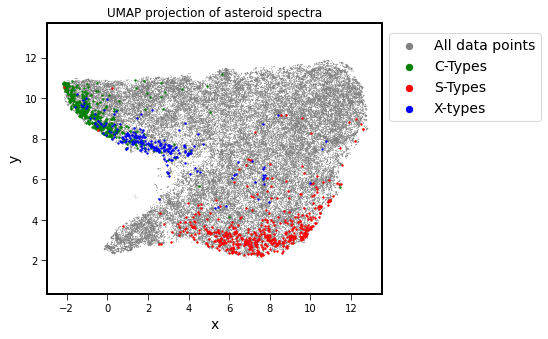

In [16]:
sso_types_list = list(ssotypes.values()) #Transforms the types type from dictionary to a list so we can use them more easily  
#objects = list(ssotypes.keys())     #Name of the objects in the dictionary

C_types = sso_types_list[0]
other = sso_types_list[1]
rest = sso_types_list[2]

plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s = 0.03, label = 'All data points', color = 'gray')
plt.scatter(
    embedding[:, 0][all_c_indeces],
    embedding[:, 1][all_c_indeces], color = 'g', s = 1.8, label = 'C-Types')
plt.scatter(
    embedding[:, 0][all_S_indeces],
    embedding[:, 1][all_S_indeces], color = 'r', s = 1.8, label = 'S-Types')
plt.scatter(
    embedding[:, 0][all_X_indeces],
    embedding[:, 1][all_X_indeces], color = 'b', s = 1.8, label = 'X-types')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of asteroid spectra');
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
#plt.axvline(x=0.402, ymin=0.4, ymax = 0.615, linewidth=2, color='k')
lgnd = plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.8),scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
plt.savefig('UMAP 2D.jpg', bbox_inches  = 'tight')
plt.show()

In [17]:
MP3C_catalogue = pd.read_csv('mp3c-best-values-search.txt', sep='\t')
sso_number_mp = np.unique(ssospectra.number_mp)
MP3C = MP3C_catalogue.loc[np.isin(MP3C_catalogue['# number'], sso_number_mp)]

red = MP3C.e.values
blue = MP3C.a.values
green = MP3C.sin_i.values

<ipython-input-17-c0894cd0875a>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  MP3C_catalogue = pd.read_csv('mp3c-best-values-search.txt', sep='\t')


In [18]:
red_2 = []
for i in red:
    if i < 0.4:
        red_2.append(i)
    else:
        red_2.append(0)

blue_2 = []
for i in blue:
    if i < 4:
        blue_2.append(i)
    else:
        blue_2.append(0)

green_2 = []
for i in green:
    if i < 0.55:
        green_2.append(i)
    else:
        green_2.append(0)

red_2 = red_2/np.max(red_2)
green_2 = green_2/np.max(green_2)
blue_2 = blue_2/np.max(blue_2)

rgb = [list(pair) for pair in zip(red_2,green_2,blue_2)]

In [19]:
zeros = np.zeros(len(MP3C))

only_red = [list(pair) for pair in zip(red_2,zeros,zeros)]
only_green = [list(pair) for pair in zip(zeros,green_2,zeros)]
only_blue = [list(pair) for pair in zip(zeros,zeros,blue_2)]



In [20]:
a = 1.3
b = 1.3
a2 = 1.2

inner_ellipse = (((embedding[:, 0]-11)/a)**2 + ((embedding[:, 1]-9.8)/b)**2 ) < 1.5
outer_ellipse = (((embedding[:, 0]-11)/a2)**2 + ((embedding[:, 1]-9.8)/b)**2 ) < 2.5

stroke = ((((embedding[:, 0]-11)/a)**2 + ((embedding[:, 1]-9.8)/b)**2 ) > 1.5) & outer_ellipse

In [21]:
len(MP3C[stroke]), len(MP3C[outer_ellipse])

(2596, 8637)

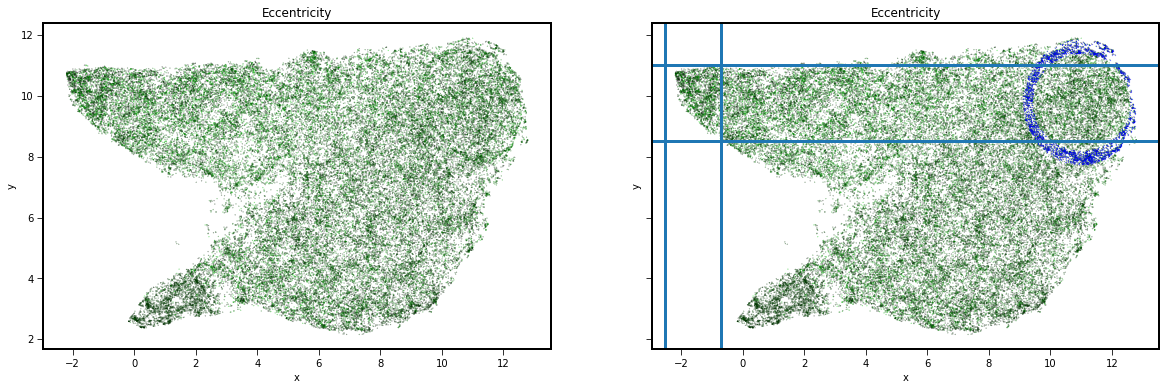

In [22]:
fig,  (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6), sharex=True, sharey=True)
ax1.scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = only_green)
ax1.set_title('Eccentricity')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = only_green)
ax2.scatter(embedding[:, 0][stroke], embedding[:, 1][stroke], s = 0.03, label = 'inner ellipse', c = 'b')
ax2.set_title('Eccentricity')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.axhline(11)
plt.axhline(8.5)
plt.axvline(-0.7)
plt.axvline(-2.55)


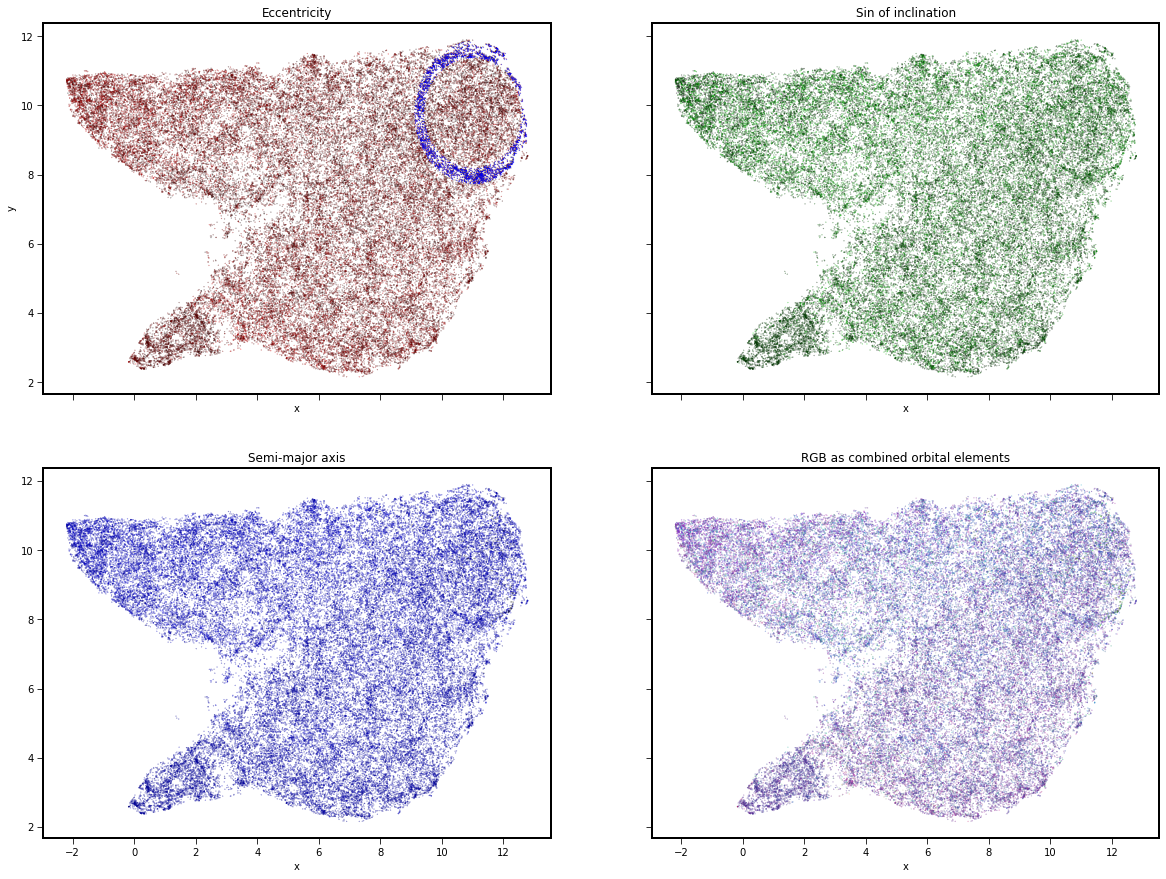

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(20,15), sharex=True, sharey=True)
axs[0,0].scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = only_red)
axs[0,0].scatter(embedding[:, 0][stroke], embedding[:, 1][stroke], s = 0.03, label = 'inner ellipse', c = 'b')
axs[0,0].set_title('Eccentricity')
axs[0,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

axs[0,1].scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = only_green)
axs[0,1].set_title('Sin of inclination')
axs[0,1].set_xlabel('x')

axs[1,0].scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = only_blue)
axs[1,0].set_title('Semi-major axis')
axs[1,0].set_xlabel('x')
axs[0,0].set_ylabel('y')

axs[1,1].scatter(embedding[:, 0], embedding[:, 1], s = 0.03, label = 'All data points', c = rgb)
axs[1,1].set_title('RGB as combined orbital elements')
axs[1,1].set_xlabel('x')
plt.savefig('rgb_umap_OP.pdf')
plt.show()

In [24]:
upper_left = (embedding[:, 0]>-2.5) & (embedding[:, 0]<-0.7) &  (embedding[:, 1]>8.5) &  (embedding[:, 1]<11.5) 
bottom_left = (embedding[:, 0]>-0.4) & (embedding[:, 0]<2.5) &  (embedding[:, 1]>2) &  (embedding[:, 1]<5) 
print(np.mean(red_2), np.mean(green_2), np.mean(blue_2))
print(np.mean(red_2[bottom_left]), np.mean(green_2[bottom_left]), np.mean(blue_2[bottom_left]))
print(100*(np.mean(red_2[bottom_left])-np.mean(red_2))/np.mean(red_2))
print(100*(np.mean(green_2[bottom_left])-np.mean(green_2))/np.mean(green_2))
print(100*(np.mean(blue_2[bottom_left])-np.mean(blue_2))/np.mean(blue_2))

print()
print(np.mean(red_2[upper_left]), np.mean(green_2[upper_left]), np.mean(blue_2[upper_left]))
print(100*(np.mean(red_2[upper_left])-np.mean(red_2))/np.mean(red_2))
print(100*(np.mean(green_2[upper_left])-np.mean(green_2))/np.mean(green_2))
print(100*(np.mean(blue_2[upper_left])-np.mean(blue_2))/np.mean(blue_2))

print()
print(np.mean(red_2[stroke]), np.mean(green_2[stroke]), np.mean(blue_2[stroke]))
print(100*(np.mean(red_2[stroke])-np.mean(red_2))/np.mean(red_2))
print(100*(np.mean(green_2[stroke])-np.mean(green_2))/np.mean(green_2))
print(100*(np.mean(blue_2[stroke])-np.mean(blue_2))/np.mean(blue_2))


0.3592907649047406 0.3018400839715371 0.6551867223778166
0.31072394351109245 0.21933851283857492 0.591348130062278
-13.517414344486355
-27.33287443053518
-9.74357234894112

0.4289295935191636 0.30031818973695706 0.6976457576921704
19.382304088134987
-0.5042054768059093
6.480448071392629

0.3296541159446696 0.3122586460382503 0.6541201293590946
-8.24865313972894
3.45168273531744
-0.16279222125429038


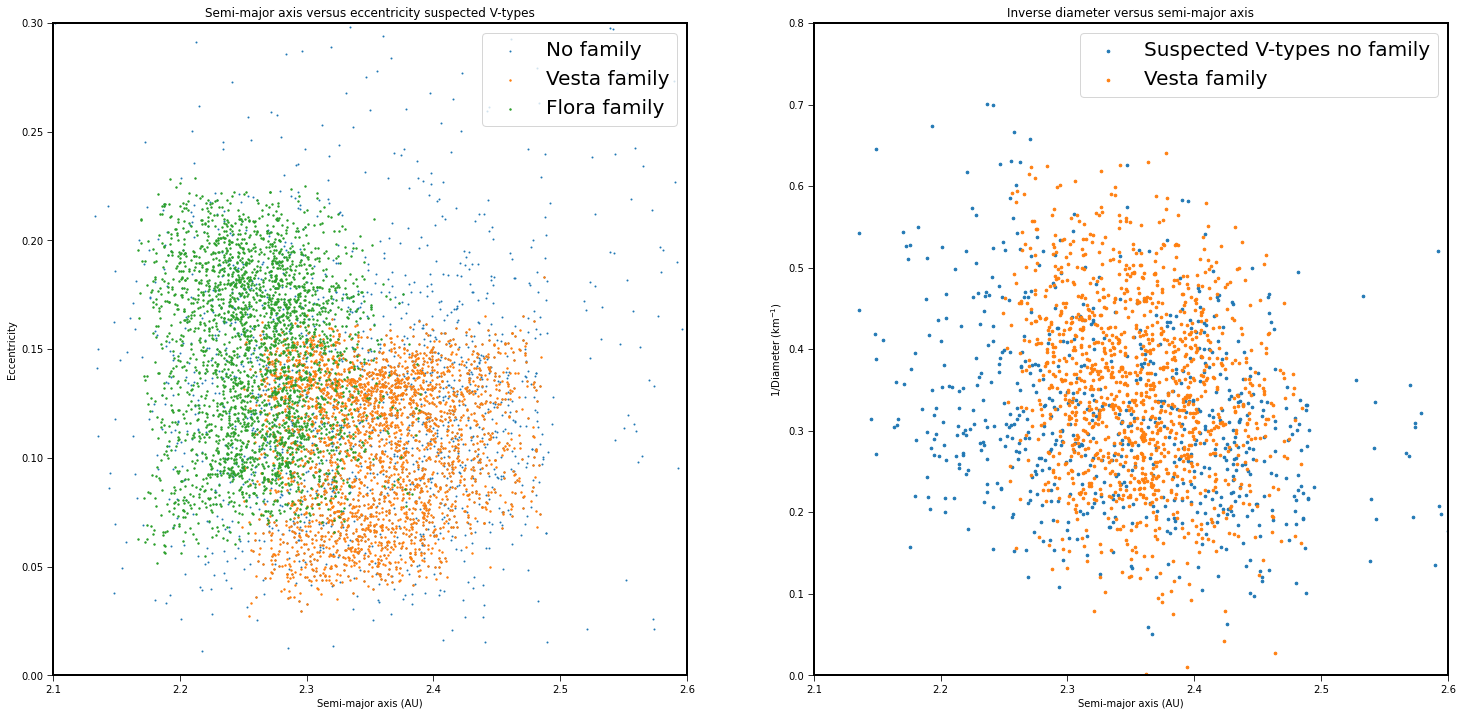

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,12), sharex=True, sharey=False)
ax1.scatter(MP3C.a[bottom_left], MP3C.e[bottom_left], s = 1, label = 'No family')
ax1.scatter(MP3C.a[MP3C.parent_name == 'Vesta'], MP3C.e[MP3C.parent_name == 'Vesta'], s = 2, label = 'Vesta family')
ax1.scatter(MP3C.a[MP3C.parent_name == 'Flora'], MP3C.e[MP3C.parent_name == 'Flora'], s = 2, label = 'Flora family')
ax1.set_xlim(2.1,2.5)
ax1.set_ylim(0,0.3)
ax1.set_title('Semi-major axis versus eccentricity suspected V-types')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.set_ylabel('Eccentricity')
ax1.legend(fontsize = 20, loc = 'upper right')

ax2.scatter(MP3C.a[bottom_left][MP3C.parent_name.isna()],MP3C.inverse_diameter[bottom_left][MP3C.parent_name.isna()], s = 7,label = 'Suspected V-types no family')
ax2.scatter(MP3C.a[MP3C.parent_name == 'Vesta'],MP3C.inverse_diameter[MP3C.parent_name == 'Vesta'], s = 7, label = 'Vesta family')
ax2.set_xlim(2.1,2.6)
ax2.set_ylim(0,0.8)

ax2.set_title('Inverse diameter versus semi-major axis')
ax2.set_xlabel('Semi-major axis (AU)')
ax2.set_ylabel('1/Diameter (km$^{-1}$)')
ax2.legend(fontsize = 20, loc = 'upper right')

#plt.savefig('OP_inverse_diameter_v_types.pdf')inverse_diameter
plt.show()

#plt.figure(figsize=(2 * 6, 2 * 4), tight_layout=True)
#plt.legend(fontsize = 15, loc = 'upper right')
#plt.savefig('V_types_suspected_families.pdf')

In [37]:
v,c, = np.unique(list(MP3C[bottom_left].parent_name), return_counts=True)
v,c

(array(['Agnia', 'Alauda', 'Baptistina', 'Barcelona', 'Brucato', 'Eos',
        'Erigone', 'Eunomia', 'Euterpe', 'Flora', 'Gallia', 'Gefion',
        'Hansa', 'Hungaria', 'Ino', 'Koronis', 'Maria', 'Massalia',
        'Meliboea', 'Merxia', 'Nysa', 'Phocaea', 'Rafita', 'Sulamitis',
        'Themis', 'Tina', 'Vesta', 'nan'], dtype='<U32'),
 array([   2,    1,    5,    9,    1,    4,    1,    6,    2,  132,    1,
           1,    8,    1,    2,    5,    4,    3,    1,    1,   16,   21,
           1,    1,    1,    1, 1302, 1426], dtype=int64))

Text(0.5, 1.0, 'Spectra of suspected V-type asteroids 1426 ')

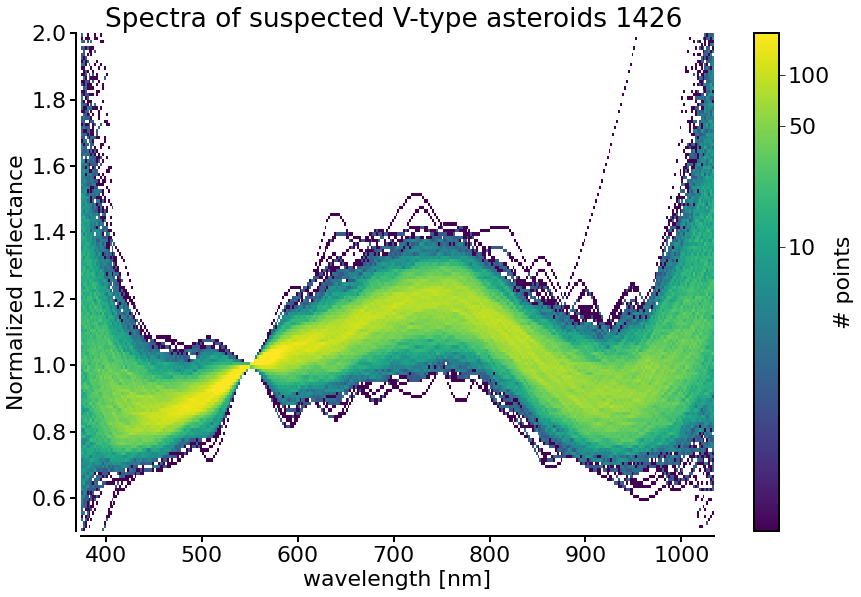

In [48]:
a = len(MP3C['# number'][bottom_left][MP3C.parent_name.isna()])
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, MP3C['# number'][bottom_left][MP3C.parent_name.isna()], cbarticks=[10, 50, 100, 1000])
plt.title(f'Spectra of suspected V-type asteroids {a} ')

Text(0.5, 1.0, 'Spectra Vesta asteroids')

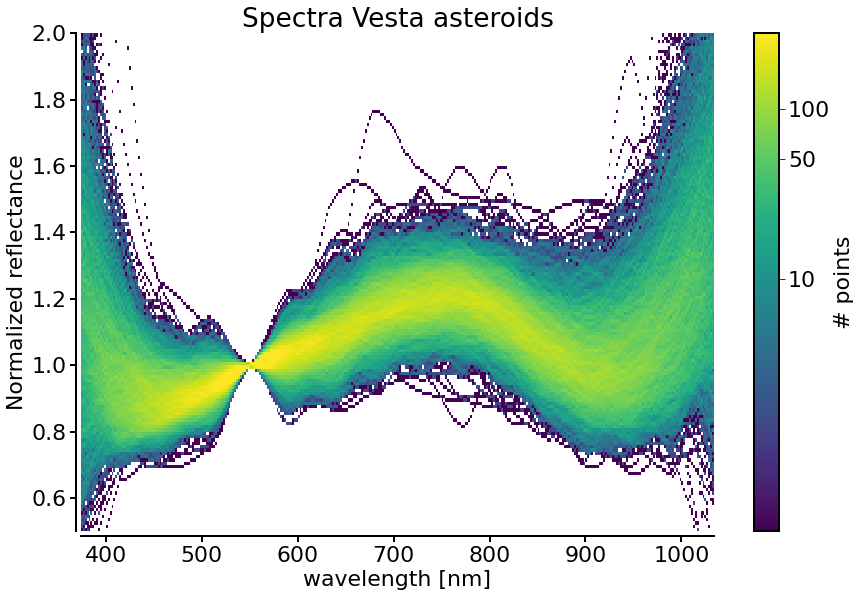

In [49]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, MP3C['# number'][MP3C.parent_name == 'Vesta'], cbarticks=[10, 50, 100, 1000])
plt.title('Spectra Vesta asteroids')

In [38]:
cond_vesta = bottom_left & (MP3C.a > 2.26) & (MP3C.a < 2.48) & (MP3C.e > 0.035) & (MP3C.e < 0.162) & (MP3C.sin_i > 0.087) &(MP3C.sin_i < 0.144) #For between Kirkwoods: & (MP3C.a > 2.068) & (MP3C.a < 2.502) #For boundary: & (MP3C.a > 2.26) & (MP3C.a < 2.48) & (MP3C.e > 0.035) & (MP3C.e < 0.162) & (MP3C.sin_i > 0.087) &(MP3C.sin_i < 0.144) 
new_members = MP3C[cond_vesta]
#np.savetxt('new_members_vesta.csv', new_members[new_members.parent_name.isna()]['# number'])


In [43]:
np.unique(list(new_members.parent_name), return_counts = True)

(array(['Baptistina', 'Flora', 'Vesta', 'nan'], dtype='<U32'),
 array([   2,   26, 1278,  545], dtype=int64))

In [ ]:
vesta_mp = np.genfromtxt('images/vesta/new_members_vesta.csv')
MP3C_vesta = MP3C_catalogue.loc[np.isin(MP3C_catalogue['# number'], vesta_mp)]
MP3C_vesta

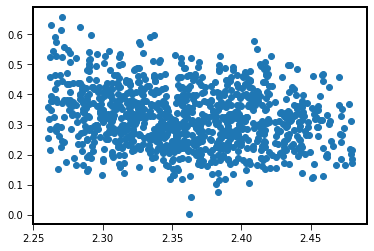

In [44]:
new_members[new_members.parent_name.isna()]
plt.scatter(new_members.a,new_members.inverse_diameter)


In [57]:
vesta_mp = np.genfromtxt('MP_numbers\Vesta_between Kirkwood_gaps.txt', delimiter=',')

In [ ]:
MP3C['# number'][bottom_left][MP3C.parent_name.isna()]

348          349.0
645          646.0
853          854.0
901          902.0
1458        1459.0
            ...   
310727    310728.0
326363    326364.0
327793    327794.0
337065    337066.0
339680    339681.0
Name: # number, Length: 1426, dtype: float64

In [ ]:
v,c = np.unique(list(MP3C['number'][bottom_left][MP3C.parent_name.isna()]),return_counts = True)

(array([nan]), array([1426], dtype=int64))

In [82]:
len(list(new_members['# number']))

2734

In [65]:
np.savetxt('Vesta_between Kirkwood_gaps.txt', np.array([list(MP3C['# number'][bottom_left][MP3C.parent_name.isna()])]), delimiter=', ', fmt='%.0f')

Text(0.5, 1.0, 'Spectra possible new Vesta members')

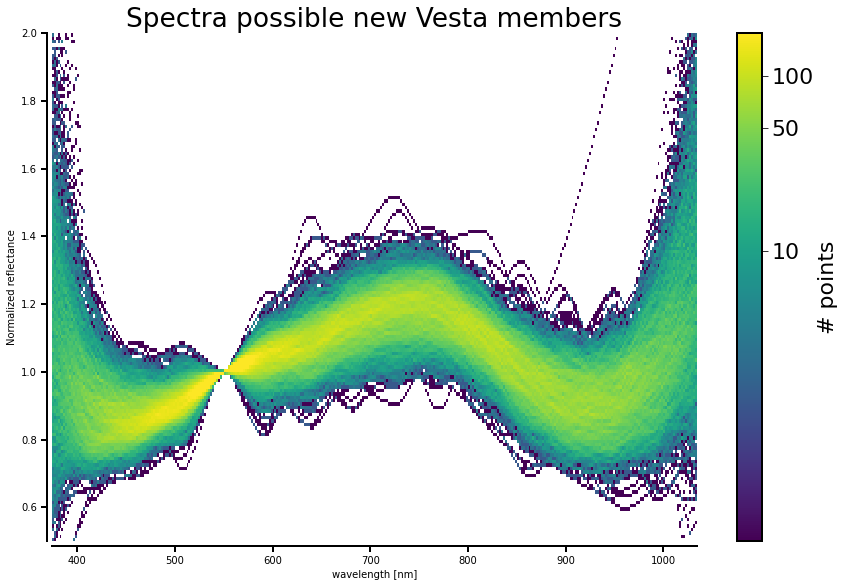

In [66]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, MP3C['# number'][bottom_left][MP3C.parent_name.isna()], cbarticks=[10, 50, 100, 1000])
plt.title('Spectra possible new Vesta members')

In [ ]:
v, c = np.unique(list(type_asteroids), return_counts=True)
v, c

(array(["['O']", "['R']", "['S:']", "['Sq']", "['V']", '[nan]'],
       dtype='<U6'),
 array([   2,    4,    1,    5,   38, 2909], dtype=int64))

(2.2, 2.45)

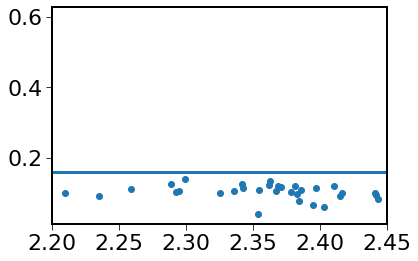

In [ ]:
index_v_types = types.pdes[types.spec_B == 'V'].index
plt.scatter(MP3C.a[index_v_types], MP3C.sin_i[index_v_types])
plt.axhline(0.16)
plt.xlim(2.2,2.45)

['B' 'C' 'Cb' 'Cg' 'Cgh' 'Ch' 'Q' 'S' 'Sq' 'X' 'Xc' 'nan'] 2631
56 [   1   85   96    5    2    1    1   19   10    1    1   13    1   61
    1    6   21    9   17   39    2    3    1    7    9   62    1    3
    1    5    7    1    1    4    2    2    3   27    7   38    2    3
  109   40   11    1    3    2    1    1  329   10   12    7   13 1511]


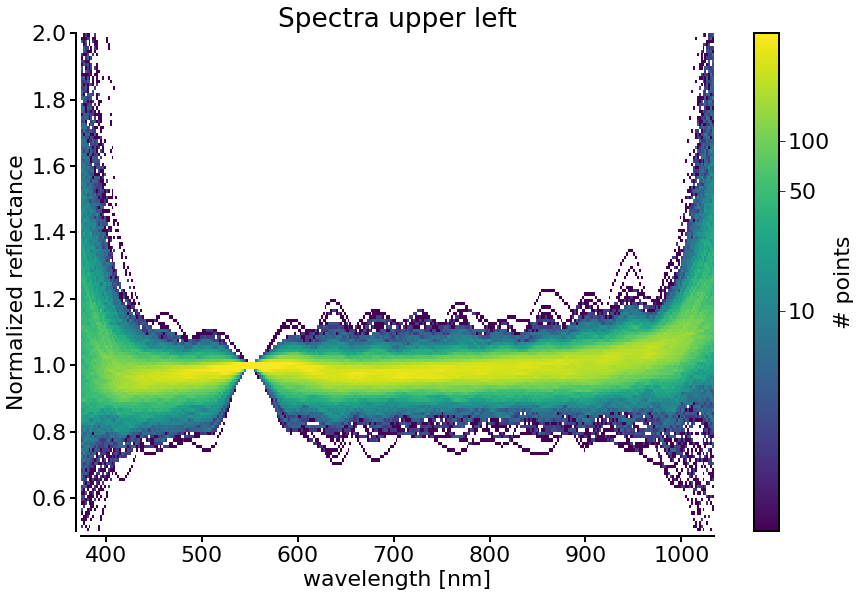

In [ ]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, types.pdes[upper_left].values, cbarticks=[10, 50, 100, 1000])
plt.title('Spectra upper left')

v, c = np.unique(list(types.spec_B[upper_left]), return_counts=True)
print(v, sum(c))

v, c = np.unique(list(MP3C.parent_name[upper_left]), return_counts=True)
print(len(v), c)

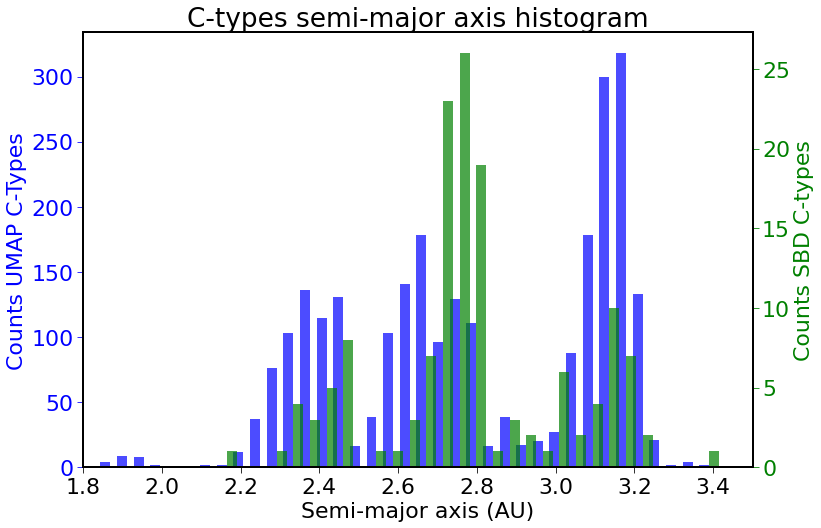

In [ ]:
fig, ax1= plt.subplots(figsize = (12,8))
ax2 = ax1.twinx()
ax1.hist([MP3C.a[upper_left], MP3C.a[types.spec_B == 'C']], bins = 1000, alpha = 0.7)
n, bins, patches = ax1.hist([MP3C.a[upper_left], MP3C.a[types.spec_B == 'C']], bins = 1000)
ax1.cla()
width = (bins[1] - bins[0]) *0.6
bins_shifted = bins+width
ax1.bar(bins[:-1], n[0], width, align = 'edge', color = 'b', alpha = 0.7)
ax2.bar(bins_shifted[:-1], n[1], width, align = 'edge', color = 'g', alpha = 0.7)

ax1.set_ylabel('Counts UMAP C-Types', color = 'b')
ax1.set_title('C-types semi-major axis histogram')
ax2.set_ylabel('Counts SBD C-types', color = 'g')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.tick_params('y', colors = 'b')
ax2.tick_params('y', colors = 'g')

plt.xlim(1.8,3.5)
plt.savefig('c_types_axis_histogram_umap.png')

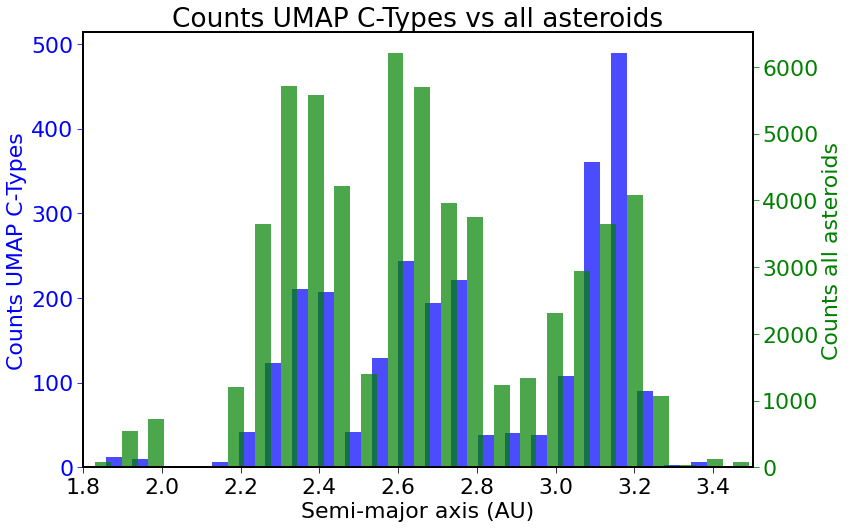

In [ ]:
fig, ax1 = plt.subplots(figsize = (12,8))
ax2 = ax1.twinx()
ax1.hist([MP3C.a[upper_left], MP3C.a], bins = 1000, alpha = 0.7)
n, bins, patches = ax1.hist([MP3C.a[upper_left], MP3C.a], bins = 1000)
ax1.cla()
width = (bins[1] - bins[0]) *0.6
bins_shifted = bins+width
ax1.bar(bins[:-1], n[0], width, align = 'edge', color = 'b', alpha = 0.7)
ax2.bar(bins_shifted[:-1], n[1], width, align = 'edge', color = 'g', alpha = 0.7)

ax1.set_ylabel('Counts UMAP C-Types', color = 'b')
ax1.set_title('Counts UMAP C-Types vs all asteroids')
ax2.set_ylabel('Counts all asteroids', color = 'g')
ax1.set_xlabel('Semi-major axis (AU)')
ax1.tick_params('y', colors = 'b')
ax2.tick_params('y', colors = 'g')

plt.xlim(1.8,3.5)
plt.savefig('all_asteroids_axis_histogram_umap.png')

['D' 'K' 'L' 'Ld' 'S' 'Sl' 'T' 'U' 'X' 'nan'] [   9    1    2    3    4    1    3    1    1 8612]
['1993 FY12' '1999 CG1' '1999 XT17' '2000 BY6' 'Adeona' 'Aegle' 'Aeria'
 'Agnia' 'Alauda' 'Anfimov' 'Armenia' 'Baptistina' 'Barcelona' 'Brangane'
 'Brasilia' 'Brucato' 'Charis' 'Chimaera' 'Chloris' 'Croatia' 'Dora'
 'Durisen' 'Emma' 'Ennomos' 'Eos' 'Erigone' 'Eunomia' 'Euphrosyne'
 'Eurybates' 'Euterpe' 'Flora' 'Fringilla' 'Gallia' 'Gefion' 'Gersuind'
 'Hansa' 'Hektor' 'Henan' 'Hilda' 'Hoffmeister' 'Hungaria' 'Hygiea' 'Ino'
 'Itha' 'Juliana' 'Juno' 'Karma' 'Kazuya' 'Klio' 'Konig' 'Koronis'
 'Leonidas' 'Lixiaohua' 'Lucienne' 'Luthera' 'Marconia' 'Maria' 'Massalia'
 'Meliboea' 'Merxia' 'Misa' 'Mitidika' 'Nemesis' 'Nysa' 'Padua' 'Phaeo'
 'Phocaea' 'Postrema' 'Rafita' 'Schubart' 'Shaulladany' 'Sulamitis'
 'Sylvia' 'Telramund' 'Themis' 'Thronium' 'Tirela' 'Ursula' 'Veritas'
 'Vesta' 'Watsonia' 'Witt' 'Xizang' 'nan'] [   1    9    3    3   13   16    4    9   32    1    1    4    4    4
    6   

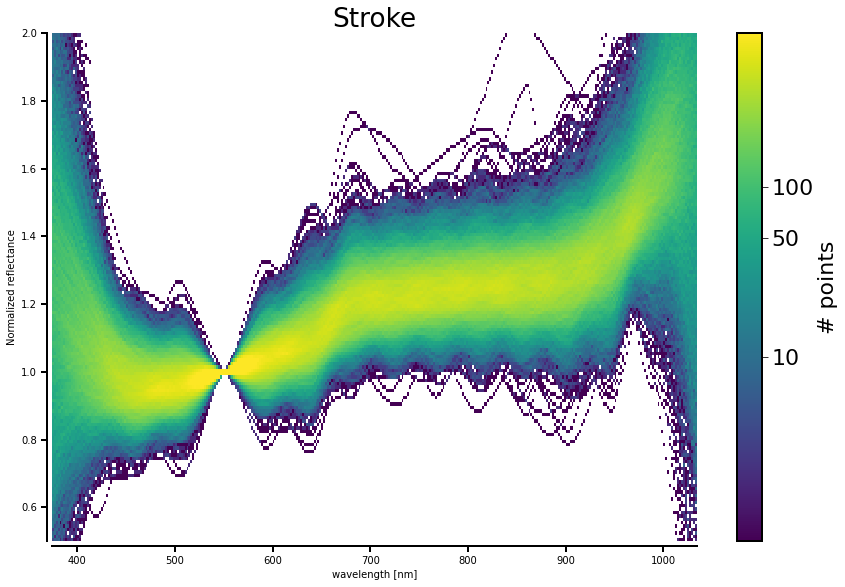

In [ ]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, types.pdes[outer_ellipse].values, cbarticks=[10, 50, 100, 1000])
plt.title('Stroke')

v, c = np.unique(list(types.spec_B[outer_ellipse]), return_counts=True)
print(v, c)

v, c = np.unique(list(MP3C.parent_name[outer_ellipse]), return_counts=True)
print(v, c)

(2.0, 3.5)

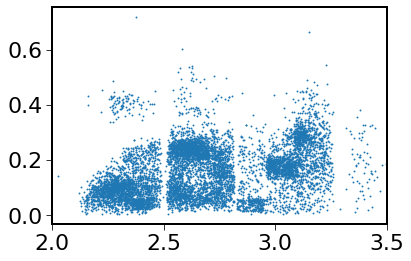

In [ ]:
plt.scatter(MP3C.a[outer_ellipse], MP3C.sin_i[outer_ellipse], s = 0.8)
plt.xlim(2,3.5)
#plt.xlim(0,0.3)

The already known data types seem not to be randomly distributed. Maybe we got a biased distribution of types. 

We can do the same as UMAP using the T-distributed stochastic neighbor embedding method. This produces a relatively similar image.

In [ ]:
#X_embedded = TSNE().fit_transform(data_to_be_classified)
#X_embedded.shape

In [ ]:
"""
X = data_to_be_classified

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]

for n_clusters in range_n_clusters:

    ### FIRST, DO THE ACTUAL CLUSTERING ###

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is :{silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)


    ### SET UP THE TWO-PLOT FIGURE ###

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)


    ### LEFT PLOT ###

    # The 1st subplot is the silhouette plot
    ax1.set_title("The silhouette plot for the various clusters.")

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_xlim([-0.1, 1])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylabel("Cluster label")
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax1.set_yticks([])  # Clear the yaxis labels / ticks

    

    y_lower = 10  # starting position on the y-axis of the next cluster to be rendered

    for i in range(n_clusters): # Here we make the colored shape for each cluster

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # Figure out how much room on the y-axis to reserve for this cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        y_range = np.arange(y_lower, y_upper)

        # Use matplotlib color maps to make each cluster a different color, based on the total number of clusters.
        # We use this to make sure the colors in the right plot will match those on the left.
        color = cm.nipy_spectral(float(i) / n_clusters)

        # Draw the cluster's overall silhouette by drawing one horizontal stripe for each datapoint in it
        ax1.fill_betweenx(y=y_range,                            # y-coordinates of the stripes
                          x1=0,                                 # all stripes start touching the y-axis
                          x2=ith_cluster_silhouette_values,     # ... and they run as far as the silhouette values
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")



    ### RIGHT PLOT ###

    # 2nd Plot showing the actual clusters formed
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
                 fontsize=14, fontweight='bold')

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)  # make the colors match with the other plot
    ax2.scatter(embedding[:, 0], embedding[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    ## Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    ## Put numbers in those circles
    #for i, c in enumerate(centers):
    #    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')




### FINISH ###
plt.show()  # show all the plots, in the order they were generated
"""

'\nX = data_to_be_classified\n\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]\n\nfor n_clusters in range_n_clusters:\n\n    ### FIRST, DO THE ACTUAL CLUSTERING ###\n\n    # Initialize the clusterer with n_clusters value and a random generator\n    # seed of 10 for reproducibility.\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n\n    # The silhouette_score gives the average value for all the samples.\n    # This gives a perspective into the density and separation of the formed\n    # clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print(f"For n_clusters = {n_clusters}, the average silhouette_score is :{silhouette_avg}")\n\n    # Compute the silhouette scores for each sample\n    sample_silhouette_values = silhouette_samples(X, cluster_labels)\n\n\n    ### SET UP THE TWO-PLOT FIGURE ###\n\n    # Create a subplot with 1 row and 2 columns\n    fig, (ax1, ax2) = plt.subplots(1, 2)\n    fig.set_size_inches

We will now implement the K-means usupervised clusering algorithm. For the algorithm to work, we need to specify the amount of clusters we think the data will have. We can determine this value by looking at a range of values and looking for the 'elbow point' wher the graph significantly reduces its slope

In [ ]:
def optimise_k_means(data, max_k):
    means = []
    inertia = []
    for k in range(1, max_k):
        kmean = KMeans(n_clusters = k)
        kmean.fit(data)
        
        means.append(k)
        inertia.append(kmean.inertia_)
        
    fig = plt.subplots(figsize = (9,5))
    plt.title('Inertia plot of K-Means clustering')
    plt.plot(means, inertia, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.savefig('Inertia_plot_Kmeans_no_data_reduction.pdf', dpi=300, bbox_inches = "tight")
    plt.show()

c:\Users\rikal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rikal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rikal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\rikal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

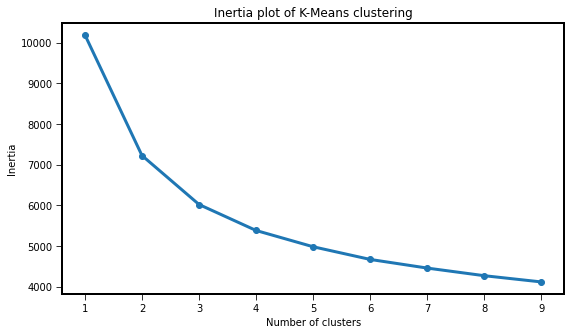

In [ ]:
optimise_k_means(data_to_be_classified, 10)

We see that the slope reduces significantly around k = 4, 5, 6. For now we will use k = 5 to fit all the data.

In [ ]:
number_of_clusters = 7

kmean = KMeans(n_clusters = number_of_clusters)
kmean.fit(data_to_be_classified)
labels = kmean.labels_

c:\Users\rikal\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We now look at where the distribution of these clusters. We do this by looking at the UMAP and giving all the points in the same cluster the same colour.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1440x288 with 0 Axes>

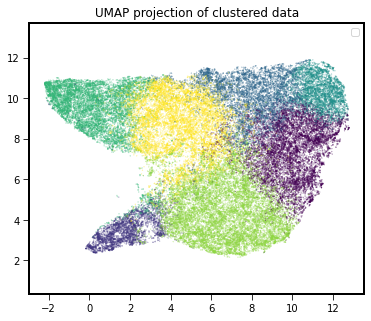

In [ ]:
plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s = 0.03, c = labels)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of clustered data')
plt.legend(prop={'size': 10})
plt.show()

We see that the K-means clustering method translates really well to the UMAP mapp. It clusters data that are also really close in the UMAP plot.

### K means clustering groups spectra

In [ ]:
#unique_labels = np.unique(labels)
#for n in unique_labels:
#    i=1
#    group = []
#    non_group_indices = []
#    while i <len(labels)+1:
#            if labels[i-1] == n:
#                index_ssospectra = (i*16)-1
#                mp_number = ssospectra.number_mp[index_ssospectra]
#                group.append(mp_number)
#                i+=1
#            else:
#                index_ssospectra = (i*16)-1
#                non_group_indices.append(i)
#                i+=1
#
#
#
#    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#    gs = GridSpec(2, 2, figure=fig)
#    axspectra = []
#    axspectra.append(fig.add_subplot(gs[0, 0]))
#    for axx in axspectra:
#        apply_tufte(axx)
#
#    plt.rcParams.update({'font.size': 22})
#    plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100, 1000])
#    plt.title(f'Without 374 and 1034 nm')

In [6]:
unique_wavelengths = np.unique(ssospectra.wavelength)
training_spectra, training_labels, data_to_be_classified_2 = prep_classifier_inputs(
    ssospectra, ssotypes
)

df_values = pd.DataFrame(data_to_be_classified_2, columns = unique_wavelengths, index = np.unique(ssospectra.number_mp))
condition = (df_values[1034] < df_values[990]) & (df_values[990] > df_values[946]) & (df_values[990] > 1.1) & (df_values[990] < 1.4) & (df_values[902] < 1.12) & (df_values[858] < 1.12) & (df_values[858] >0.8) & (df_values[814] < 1.12) & (df_values[770] < 1.12) & (df_values[726] < 1.12)  
condition_peak_all_asteroids = (df_values[1034] < df_values[990]) & (df_values[990] > df_values[946]) & (df_values[990] > 1.1) 
peak_c_types = df_values[condition]
peak_all_asteroids = df_values[condition_peak_all_asteroids]
#Delete from 4th condition onwards to get all spectra with peaked feature

In [7]:
len(peak_all_asteroids)

11563

In [8]:
sso_spectra_condition = np.repeat(condition, 16)
sso_spectra_piek = ssospectra[sso_spectra_condition.values]
flags = sso_spectra_piek[ssospectra.wavelength == 1034].reflectance_spectrum_flag

#index = sso_spectra_piek[ssospectra.wavelength == 1034].reflectance_spectrum_flag.index

values, counts = np.unique(flags, return_counts=True)
print(values, counts)

[0 1 2] [782   7 463]


<ipython-input-8-1c783d2c0e78>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flags = sso_spectra_piek[ssospectra.wavelength == 1034].reflectance_spectrum_flag


In [9]:
flags_2_mp_numbers = sso_spectra_piek[ssospectra.reflectance_spectrum_flag == 2]
a = np.unique(flags_2_mp_numbers.number_mp)
for i in a:
    sso_spectra_piek.drop(sso_spectra_piek[sso_spectra_piek.number_mp == i].index, inplace=True)

<ipython-input-9-2c833af05b31>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flags_2_mp_numbers = sso_spectra_piek[ssospectra.reflectance_spectrum_flag == 2]
<ipython-input-9-2c833af05b31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sso_spectra_piek.drop(sso_spectra_piek[sso_spectra_piek.number_mp == i].index, inplace=True)


In [10]:
filtered_piek_mp_numbers = np.unique(sso_spectra_piek.number_mp)

In [11]:
len(np.unique(ssospectra[ssospectra.reflectance_spectrum_flag == 2].number_mp))

45552

Text(0.5, 1.0, 'Peaked C-type spectrum of 310 asteroids')

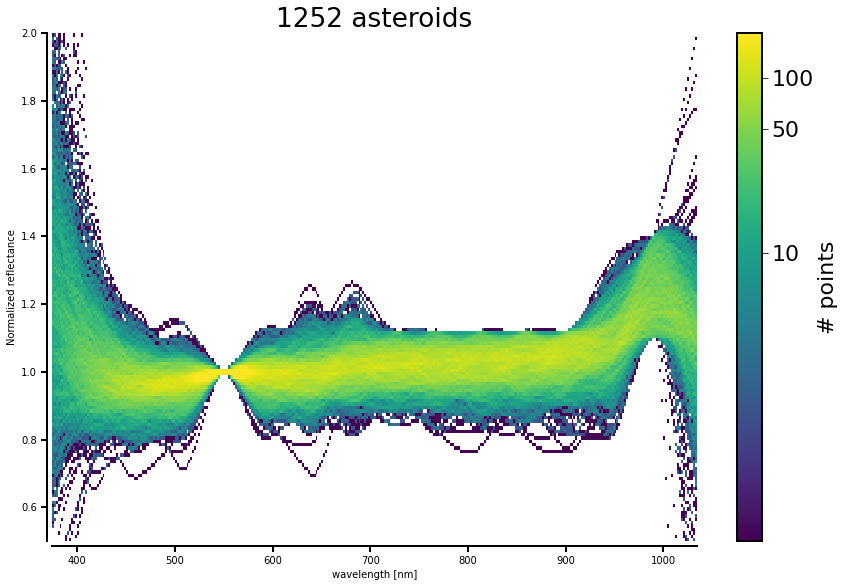

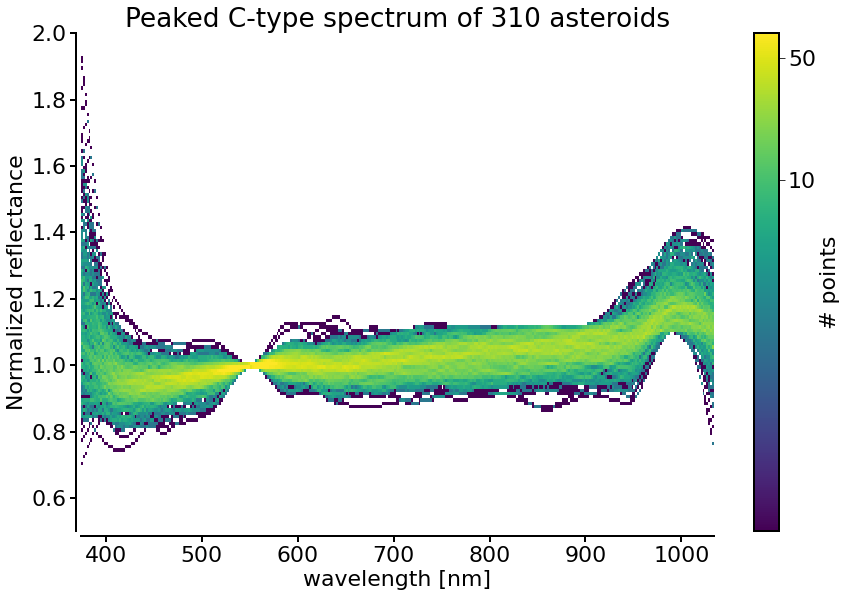

In [12]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, peak_c_types.index, cbarticks=[10, 50, 100, 1000])
plt.title(f'{len(peak_c_types)} asteroids')

fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, filtered_piek_mp_numbers, cbarticks=[10, 50, 100, 1000])
plt.title(f'Peaked C-type spectrum of {len(filtered_piek_mp_numbers)} asteroids')

In [15]:
types = pd.read_csv('sbdb_query_results.csv')
spectral_types = types.loc[np.isin(types['pdes'], sso_number_mp)]

<ipython-input-15-eb5bbc67c023>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  types = pd.read_csv('sbdb_query_results.csv')


In [16]:
filtered_piek_mp_numbers

array([   331,    396,    435,    545,    562,    696,    835,    837,
          886,    922,    926,    933,    943,   1070,   1090,   1149,
         1197,   1409,   1466,   1569,   1582,   1668,   1692,   1708,
         1813,   1864,   1942,   1960,   2023,   2065,   2082,   2083,
         2142,   2240,   2328,   2330,   2372,   2563,   2711,   2816,
         2908,   2923,   2981,   3023,   3130,   3189,   3381,   3438,
         3460,   3591,   3660,   3802,   3815,   3923,   3983,   4046,
         4067,   4079,   4135,   4250,   4460,   4465,   4530,   4868,
         4944,   4967,   5070,   5177,   5210,   5290,   5411,   5822,
         5854,   5900,   5908,   5922,   6153,   6174,   6215,   6247,
         6288,   6328,   6392,   6582,   6593,   6639,   6673,   6768,
         6878,   6955,   7222,   7227,   7305,   7317,   7582,   7797,
         7817,   7833,   7835,   8147,   8314,   8514,   8673,   8712,
         9022,   9049,   9066,   9075,   9144,   9388,   9409,   9551,
      

In [22]:
np.savetxt('peaked_c_types.txt', np.array([filtered_piek_mp_numbers]), delimiter=', ', fmt='%.0f')

In [15]:
for n in np.unique(ssospectra.wavelength.values):
    wavelength1 = n
    mean_all =  np.nanmean(ssospectra.reflectance_spectrum_err[ssospectra.wavelength == wavelength1].values)
    mean_peak = np.nanmean(ssospectra.reflectance_spectrum_err[ssospectra.wavelength == wavelength1].values[condition])
    c_peak, v_peak = np.unique(ssospectra.reflectance_spectrum_flag[ssospectra.wavelength == wavelength1][condition.values], return_counts=True)
    c_all, v_all = np.unique(ssospectra.reflectance_spectrum_flag[ssospectra.wavelength == wavelength1], return_counts=True)

    percentage = 100*(mean_peak-mean_all)/mean_peak

    percentage_flag_1_peak = 100*(v_peak[1])/sum(v_peak)
    percentage_flag_1_all = 100*(v_all[1])/sum(v_all)
    percentage_flag_1_difference = 100*(percentage_flag_1_peak-percentage_flag_1_all)/percentage_flag_1_all

    if len(c_peak)>2 :
        percentage_flag_2_peak = 100*(v_peak[2])/sum(v_peak)
    else:
        percentage_flag_2_peak = 0
        v_peak = np.append(v_peak,-100)

    percentage_flag_2_all = 100*(v_all[2])/sum(v_all)
    percentage_flag_2_difference = 100*(percentage_flag_2_peak-percentage_flag_2_all)/percentage_flag_2_all

    print(n,round(percentage_flag_1_difference,2), v_peak[1] ) #, round(percentage_flag_2_difference, 2), v_peak[2] round(percentage,2), np.round(mean_all, 2), np.round(mean_peak, 2)

374.0 -48.12 6
418.0 -31.22 44
462.0 80.51 9
506.0 204.49 8
550.0 55.93 5
594.0 -63.1 2
638.0 -9.25 19
682.0 1.76 12
726.0 -26.2 2
770.0 -72.38 1
814.0 -31.92 3
858.0 -31.92 5
902.0 -49.12 9
946.0 -11.76 36
990.0 40.42 85
1034.0 -51.39 7


In [16]:
MP3C_catalogue_magnitude = pd.read_csv('mp3c-best-values-search_magnitude.txt', sep='\t')
sso_number_mp = np.unique(ssospectra.number_mp)
MP3C_mag = MP3C_catalogue_magnitude.loc[np.isin(MP3C_catalogue_magnitude['# number'], sso_number_mp)]

(10.0, 18.0)

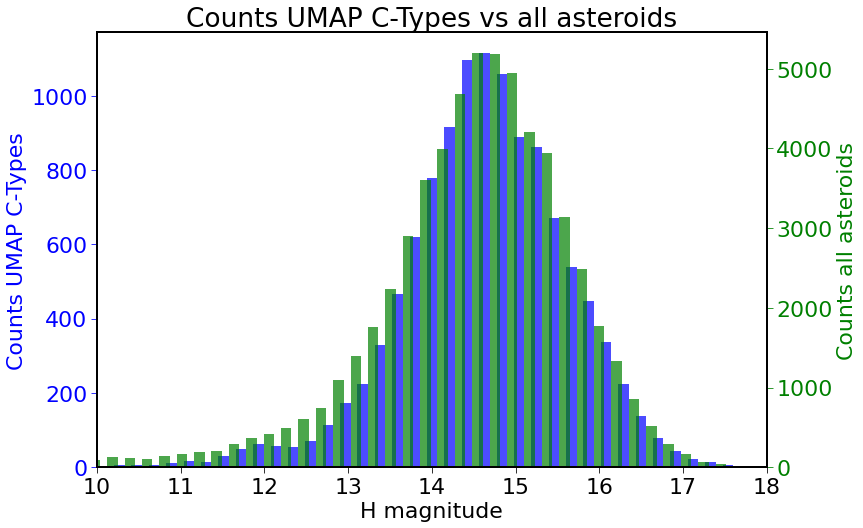

In [17]:
#MP3C_mag[condition.values].albedo
#plt.hist(MP3C_mag[condition_peak_all_asteroids.values].h, bins = 100)
#plt.hist(MP3C_mag.albedo, bins = 100)

stats.kstest(MP3C_mag[condition_peak_all_asteroids.values].h, MP3C_mag.h)

fig, ax1 = plt.subplots(figsize = (12,8))
ax2 = ax1.twinx()
ax1.hist([MP3C_mag[condition_peak_all_asteroids.values].h, MP3C_mag.h], bins = 100, alpha = 0.7)
n, bins, patches = ax1.hist([MP3C_mag[condition_peak_all_asteroids.values].h, MP3C_mag.h], bins = 100)
ax1.cla()
width = (bins[1] - bins[0]) *0.6
bins_shifted = bins+width
ax1.bar(bins[:-1], n[0], width, align = 'edge', color = 'b', alpha = 0.7)
ax2.bar(bins_shifted[:-1], n[1], width, align = 'edge', color = 'g', alpha = 0.7)

ax1.set_ylabel('Counts UMAP C-Types', color = 'b')
ax1.set_title('Counts UMAP C-Types vs all asteroids')
ax2.set_ylabel('Counts all asteroids', color = 'g')
ax1.set_xlabel('H magnitude')
ax1.tick_params('y', colors = 'b')
ax2.tick_params('y', colors = 'g')

plt.xlim(10,18)

(0.0, 0.6)

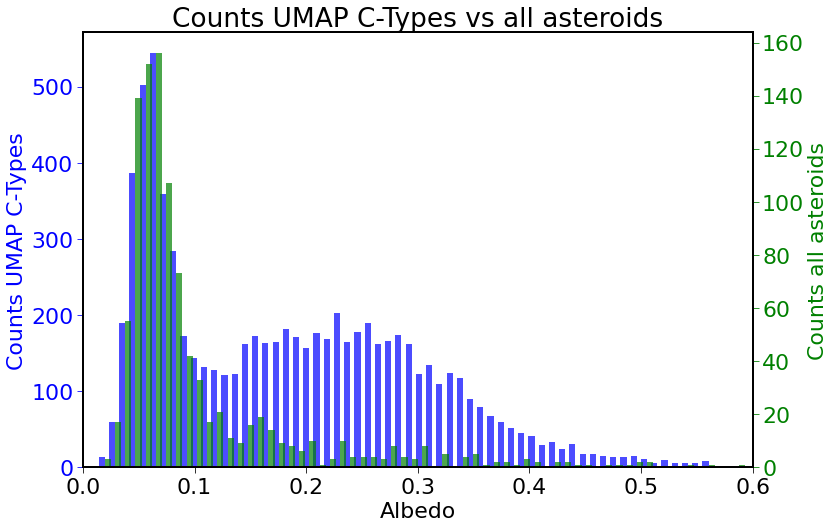

In [18]:
stats.kstest(MP3C_mag[condition_peak_all_asteroids.values].h, MP3C_mag.h)

fig, ax1 = plt.subplots(figsize = (12,8))
ax2 = ax1.twinx()
ax1.hist([MP3C_mag[condition_peak_all_asteroids.values].albedo, MP3C_mag[condition.values].albedo], bins = 100, alpha = 0.7)
n, bins, patches = ax1.hist([MP3C_mag[condition_peak_all_asteroids.values].albedo, MP3C_mag[condition.values].albedo], bins = 100)
ax1.cla()
width = (bins[1] - bins[0]) *0.6
bins_shifted = bins+width
ax1.bar(bins[:-1], n[0], width, align = 'edge', color = 'b', alpha = 0.7)
ax2.bar(bins_shifted[:-1], n[1], width, align = 'edge', color = 'g', alpha = 0.7)

ax1.set_ylabel('Counts UMAP C-Types', color = 'b')
ax1.set_title('Counts UMAP C-Types vs all asteroids')
ax2.set_ylabel('Counts all asteroids', color = 'g')
ax1.set_xlabel('Albedo')
ax1.tick_params('y', colors = 'b')
ax2.tick_params('y', colors = 'g')

plt.xlim(0,0.6)

In [19]:
MP3C_mag

# number       name     g  g_err      h  h_err  albedo  albedo_err
0            1.0      Ceres  0.15    NaN   3.34    NaN   0.106      0.0036
1            2.0     Pallas  0.15    NaN   4.12    NaN   0.150      0.0063
2            3.0       Juno  0.15    NaN   5.17    NaN   0.211      0.0083
3            4.0      Vesta  0.15    NaN   3.22    NaN   0.347      0.0104
4            5.0    Astraea  0.15    NaN   7.00    NaN   0.242      0.0108
...          ...        ...   ...    ...    ...    ...     ...         ...
398230  398231.0    2010QS1  0.15    NaN  16.40    NaN   0.086      0.0099
399321  399322.0   1998QW63  0.15    NaN  15.46    NaN   0.044      0.0075
399522  399523.0   2002XH73  0.15    NaN  16.22    NaN   0.045      0.0060
399605  399606.0  2003WL108  0.15    NaN  16.07    NaN   0.084      0.0768
399766  399767.0    2005MT4  0.15    NaN  16.07    NaN     NaN         NaN

[60518 rows x 8 columns]

In [9]:
reducer1D = umap.UMAP(random_state=42, n_neighbors=5, min_dist=0, n_components=1)
embedding_1D = reducer1D.fit_transform(data_to_be_classified)
embedding_1D.shape

c:\Users\rikal\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(60518, 1)

In [17]:
rounded = np.round(embedding_1D)
min_value = np.min(rounded)
clusters = rounded-min_value


Text(0, 0.5, 'Number of asteroids')

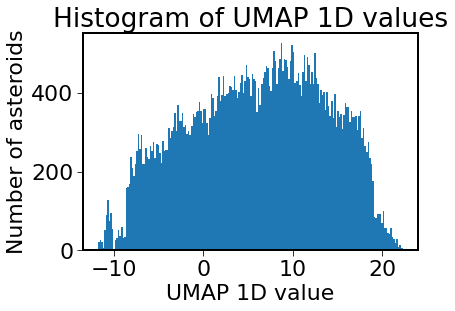

In [133]:
plt.hist(embedding_1D, bins =200)
plt.title('Histogram of UMAP 1D values')
plt.xlabel('UMAP 1D value')
plt.ylabel('Number of asteroids')

In [134]:
cond_20 = embedding_1D>20.4
cond_20 = cond_20[:,0]
group_cond_20 = np.unique(ssospectra.number_mp)[cond_20]

Text(0.5, 1.0, '349 L type asteroids')

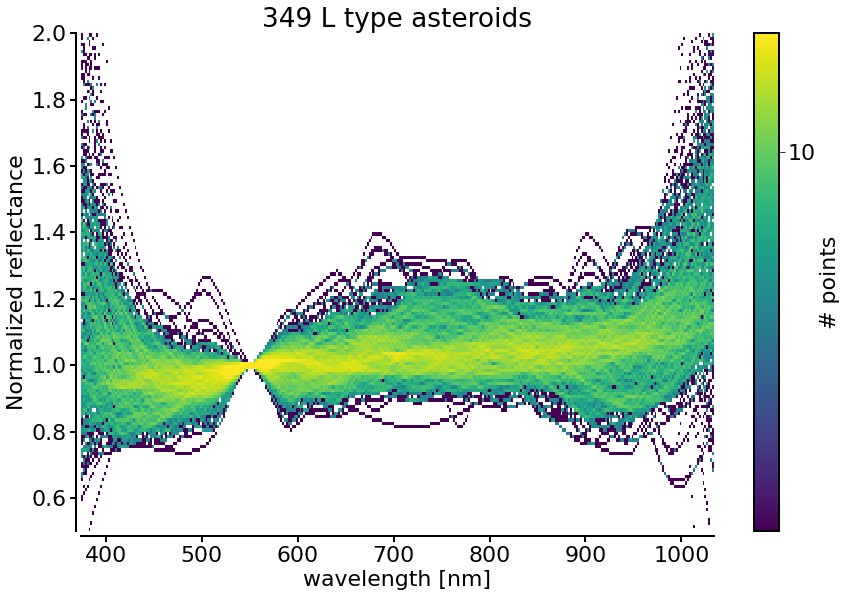

In [135]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, group_cond_20, cbarticks=[10, 50, 100, 1000])
plt.title(f'{len(group_cond_20)} L type asteroids')

In [9]:
types = pd.read_csv('sbdb_query_results.csv')

<ipython-input-9-673aa0a61ae5>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  types = pd.read_csv('sbdb_query_results.csv')


In [371]:
reducer1D = umap.UMAP(random_state=4, n_neighbors=5, min_dist=0, n_components=1)
embedding_1D = reducer1D.fit_transform(data_to_be_classified)
embedding_1D.shape

c:\Users\rikal\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(60518, 1)

In [14]:
sso_number_mp = np.unique(ssospectra.number_mp)
spectral_types = types.loc[np.isin(types['pdes'], sso_number_mp)]

In [373]:
spectral_types = spectral_types.set_index(np.linspace(0,60517, 60518, dtype=int))

In [374]:
 ssospectra_types = ssospectra.copy()
 ssospectra_types = ssospectra_types.drop(ssospectra[ssospectra.wavelength == 374].index)
 ssospectra_types = ssospectra_types.drop(ssospectra[ssospectra.wavelength == 550].index)
 ssospectra_types = ssospectra_types.drop(ssospectra[ssospectra.wavelength == 1034].index)

training_spectra, training_labels, data_to_be_classified_types = prep_classifier_inputs(
    ssospectra_types, ssotypes
)
data_to_be_classified_types[0]

array([0.9357357 , 0.95602244, 0.9843156 , 0.9876832 , 0.8999662 ,
       1.0012282 , 1.008218  , 1.0093023 , 1.0323311 , 1.0188184 ,
       1.0184406 , 1.002733  , 1.0093588 ], dtype=float32)

Calculateing mean reflectance per wavelength of JPL known types

In [375]:
pd_wavelength_mean_ref = pd.DataFrame(columns=np.unique(ssospectra_types.wavelength))

for n in np.unique(list(spectral_types.spec_B))[0:-1]:
    index_df = np.where(np.unique(list(spectral_types.spec_B)) == n)[0][0]

    indexes_type_n = spectral_types[spectral_types.spec_B == n].index
    data_type = data_to_be_classified_types[indexes_type_n]
    mean_wavelengths = np.array([])

    for m in range(0,len(data_type[0])):
        reflec_wavelength_m = data_type[:,m]
        mean_reflectance_m = np.nanmean(reflec_wavelength_m)
        mean_wavelengths = np.append(mean_wavelengths, mean_reflectance_m)

    pd_wavelength_mean_ref.loc[index_df] = mean_wavelengths

pd_wavelength_mean_ref = pd_wavelength_mean_ref.set_index(np.unique(list(spectral_types.spec_B))[0:-1])


In [376]:
rounded = 10*np.round(embedding_1D, 1)
min_value = np.min(rounded)
clusters = rounded-min_value

#rounded = np.round(embedding_1D)
#min_value = np.min(rounded)
#clusters = rounded-min_value

Calculating average of clusters

In [377]:
pd_clusters_avergage = pd.DataFrame(columns = np.unique(ssospectra_types.wavelength))

for m in np.unique(clusters):
    index = np.where(clusters == m)
    data_cluster = data_to_be_classified_types[index[0]]
    average_wavelength = np.array([])

    for n in range(0, len(data_cluster[0])):
        wavelength_n_data = data_cluster[:,n]
        average_wavelength_n = np.nanmean(wavelength_n_data)
        average_wavelength = np.append(average_wavelength,average_wavelength_n)
    pd_clusters_avergage.loc[m] = average_wavelength

In [378]:
cluster_type_prediction = pd.DataFrame(columns = ['Cluster', 'Predicted type'])

In [379]:
for j in pd_clusters_avergage.index:
    data = pd_clusters_avergage.loc[j]
    pd_wavelength_mean_ref_values = pd_wavelength_mean_ref.values
    sum_chi_squared = np.array([])
    for i in pd_wavelength_mean_ref_values:
        chi_squared = (data-i)**2
        sum_chi_squared = np.append(sum_chi_squared, np.sum(chi_squared))

    type_index_min_chi = np.where(sum_chi_squared == np.min(sum_chi_squared))[0][0]
    type_min_chi = np.unique(list(spectral_types.spec_B))[type_index_min_chi]
    #print(type_min_chi)
    #plt.plot(np.unique(ssospectra_types.wavelength), pd_wavelength_mean_ref.loc[type_min_chi].values, label = 'predicted '+ type_min_chi)
    #plt.plot(np.unique(ssospectra_types.wavelength), data, label = f'UMAP 1D cluster {j}')
    #plt.legend()
    #plt.show()
    cluster_type_prediction.loc[j] = [j, type_min_chi]

In [380]:
a = 8
column_name = f'Predicted type {a}'
spectral_types.insert(3, column_name, np.zeros(len(data_to_be_classified_types)))

In [381]:
for i in cluster_type_prediction.index:
    type = cluster_type_prediction['Predicted type'].loc[i]
    spectral_types.iloc[np.where(clusters == i)[0], 3] = type


In [382]:
mask = ~spectral_types.spec_B.isna()
label = spectral_types['spec_B'][mask]
predicted = spectral_types['Predicted type 8'][mask]

In [384]:
spectral_types

pdes spec_B     name Predicted type 8
0           1      C    Ceres                B
1           2      B   Pallas                B
2           3     Sk     Juno               Xe
3           4      V    Vesta                D
4           5      S  Astraea               Xe
...       ...    ...      ...              ...
60513  398231    NaN      NaN               S:
60514  399322    NaN      NaN               Cg
60515  399523    NaN      NaN                B
60516  399606    NaN      NaN                U
60517  399767    NaN      NaN                K

[60518 rows x 4 columns]

In [ ]:
a = 8
v, c = np.unique(spectral_types.spec_B[mask][spectral_types.spec_B == spectral_types[f'Predicted type {a}']], return_counts=True)
v_total, c_total = np.unique(spectral_types.spec_B[mask], return_counts=True)

In [277]:
dictionary = dict({
    i :[] for i in v_total
})

In [278]:
for i in v:
    index_i = np.where(v == i)
    for j in v_total:
        index_j = np.where(v_total == j)
        if i==j:
            dictionary[f'{i}'] += [round([c[index_i]/c_total[index_j]][0][0], 3)]

perfectly_classified = round(100*len(predicted[label == predicted])/len(label),1)

Taking B, C, S, X types as one

In [279]:
ch_to = ['X', 'C', 'S']
ch_from = [['Xe', 'Xc', 'Xk'], ['Cb', 'Cg','B','Cgh','Ch',], ['Sa', 'Sk' , 'Sl' , 'Sq' , 'Sr','S:']]
for i,j in zip(ch_to,ch_from):
    for n in j:
        change_from = n
        chnage_to = i
        spectral_types.iloc[np.where(spectral_types[f'Predicted type {a}'] == change_from)[0], 3] = chnage_to
        spectral_types.iloc[np.where(spectral_types['spec_B'] == change_from)[0], 1] = chnage_to

main_group_correctl = round(100*len(predicted[label == predicted])/len(label),1)

In [385]:
spectral_types[spectral_types.spec_B == spectral_types['Predicted type 8']]

pdes spec_B        name Predicted type 8
1          2      B      Pallas                B
23        24      B      Themis                B
25        26      S  Proserpina                S
30        31     Cb  Euphrosyne               Cb
46        47      B      Aglaja                B
...      ...    ...         ...              ...
7597    7817      C  Zibiturtle                C
7773    8008      C         NaN                C
9766   10199      D    Chariklo                D
11179  11785     Xc      Migaic               Xc
11602  12281      X    Chaumont                X

[193 rows x 4 columns]

In [363]:
mask

0         True
1         True
2         True
3         True
4         True
         ...  
60513    False
60514    False
60515    False
60516    False
60517    False
Name: spec_B, Length: 60518, dtype: bool

In [281]:
v, c = np.unique(spectral_types.spec_B[mask][spectral_types.spec_B == spectral_types[f'Predicted type {a}']], return_counts=True)
v_total, c_total = np.unique(spectral_types.spec_B[mask], return_counts=True)

dictionary_groups = dict({
    i :[] for i in v_total
})

In [282]:
for i in v:
    index_i = np.where(v == i)
    for j in v_total:
        index_j = np.where(v_total == j)
        if i==j:
            dictionary_groups[f'{i}'] += [round([c[index_i]/c_total[index_j]][0][0], 3)]


In [170]:
dictionary_groups

{'A': [],
 'C': [0.894],
 'D': [0.778],
 'K': [0.156],
 'L': [0.306],
 'Ld': [0.167],
 'O': [],
 'Q': [],
 'R': [],
 'S': [0.069],
 'T': [],
 'U': [],
 'V': [0.615],
 'X': [0.551]}

In [258]:
dictionary2 = dict({
    i :[] for i in set(spectral_types.spec_B)
})

In [259]:
dictionary2

{nan: [],
 'T': [],
 'X': [],
 'A': [],
 'U': [],
 'C': [],
 'S': [],
 'Ld': [],
 'R': [],
 'Q': [],
 'K': [],
 'O': [],
 'V': [],
 'L': [],
 'D': []}

In [20]:
from astropy.io import fits
data = fits.open('DR3ReflSpectraHvsNoHbandfinal.fits')[0].data
hdu_list = fits.open('DR3ReflSpectraHvsNoHbandfinal.fits')

In [21]:
hdu_list.info()
image_data = hdu_list[-1].data
ctype_pd = pd.DataFrame(data = image_data)

Filename: DR3ReflSpectraHvsNoHbandfinal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     32   8465R x 12C   [K, K, 16A, J, D, D, D, D, D, D, D, D]   


In [22]:
ctypes_mp_numbers = ctype_pd.number_mp.values
spectral_types_mees = spectral_types.loc[np.isin(spectral_types['pdes'], ctypes_mp_numbers)]

In [246]:
v,c = np.unique(spectral_types_mees[f'Predicted type {a}'], return_counts=True)

In [272]:
len(spectral_types_mees[spectral_types_mees['Predicted type 8'] == 'C'])

5671

In [254]:
spectral_types_mees[spectral_types_mees[f'Predicted type {a}'] == 'C']

dictionary_mees = dict({
    i :[] for i in v_total
})

for i in v:
    index_i = np.where(v == i)
    dictionary_mees[f'{i}'] += [round([c[index_i]/sum(c)][0][0], 3)]

In [61]:
mask = ~spectral_types.spec_B.isna()
label = spectral_types['spec_B'][mask]
predicted = spectral_types['Predicted type 6'][mask]
predicted[label == predicted]

0        C
1        C
9        C
12       C
15       X
        ..
9766     D
11179    X
11282    S
11602    X
56880    C
Name: Predicted type 6, Length: 577, dtype: object

Text(0.5, 1.0, 'Spectra Vesta asteroids')

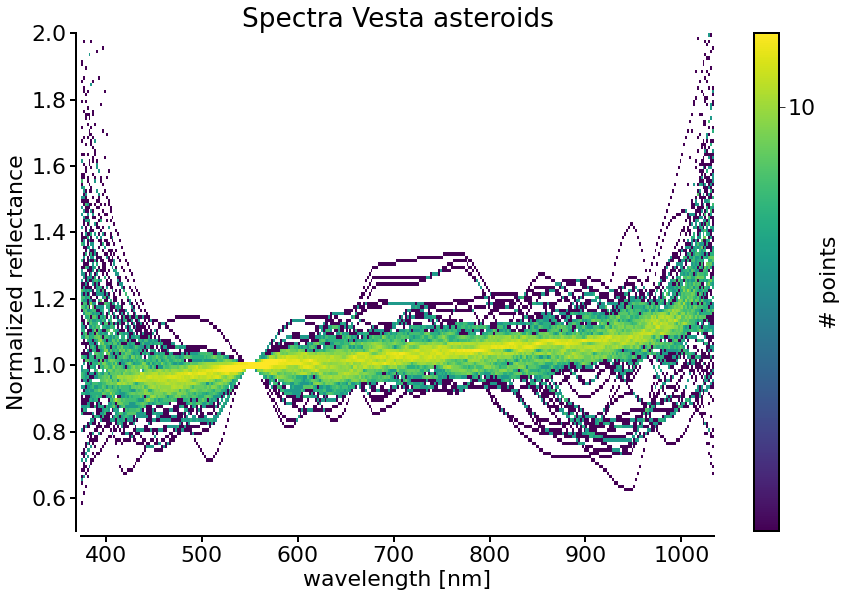

In [51]:
fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
gs = GridSpec(2, 2, figure=fig)
axspectra = []
axspectra.append(fig.add_subplot(gs[0, 0]))
for axx in axspectra:
    apply_tufte(axx)
plt.rcParams.update({'font.size': 22})
plot_spectra_collection(ssospectra, axspectra[0], fig, MP3C['# number'].iloc[clusters == 71], cbarticks=[10, 50, 100, 1000])
plt.title('Spectra Vesta asteroids')

### PLOT all SBDQ apectral types

In [ ]:
#for i in set(spectral_types.spec_B):
    a = np.array([spectral_types[spectral_types.spec_B == i].pdes])
    if len(a[0]) > 0: 
        fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
        gs = GridSpec(2, 2, figure=fig)
        axspectra = []
        axspectra.append(fig.add_subplot(gs[0, 0]))
        for axx in axspectra:
            apply_tufte(axx)
        plt.rcParams.update({'font.size': 22})
        plot_spectra_collection(ssospectra, axspectra[0], fig, a[0], cbarticks=[10, 50, 100, 1000])
        plt.title(f'{len(a[0])} {i} type asteroids')
    else:
        continue

IndentationError: unexpected indent (<ipython-input-171-3b03430a7261>, line 2)

### Plot all clusters UMAP 1D one by one

In [12]:
#for i in np.unique(clusters): 
    plt.figure().set_figwidth(20)
    plt.figure().set_figheight(5)
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1], s = 0.3, c = clusters == i)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'cluster {i}') #UMAP projection with UMAP clusters
    #plt.xlabel('x')
    #plt.ylabel('y')
    #plt.axvline(x=0.402, ymin=0.4, ymax = 0.615, linewidth=2, color='k')
    plt.legend(prop={'size': 10})
    #plt.savefig('UMAP 1D.pdf')
    plt.show()

IndentationError: unexpected indent (<ipython-input-12-143d6d8c41a5>, line 2)

In [94]:
five = [clusters == 5][0].T[0]
eight = ([clusters == 8][0].T[0]) & (embedding[:, 1] < 6) 
nine = ([clusters == 9][0].T[0]) & (embedding[:, 1] < 6) 
ten = ([clusters == 10][0].T[0]) & (embedding[:, 1] < 6) 
seventeen = [clusters == 17][0].T[0]
tt_9 = [clusters == 29][0].T[0]


<ipython-input-105-f366bcd0daff>:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [40]
<ipython-input-105-f366bcd0daff>:34: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [40]
<ipython-input-105-f366bcd0daff>:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[2]._sizes = [40]
<ipython-input-105-f366bcd0daff>:36: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[3]._sizes = [40]
<ipython-input-105-f366bcd0daff>:37: Mat

<Figure size 1440x288 with 0 Axes>

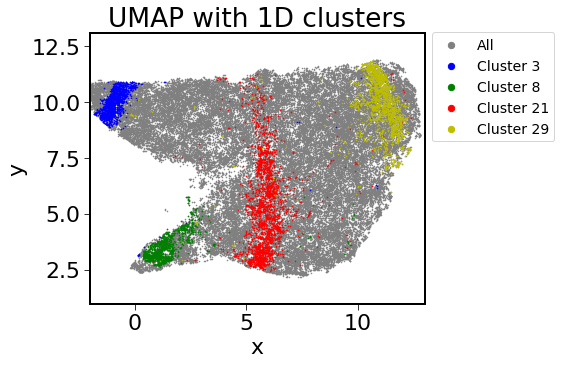

In [ ]:
plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s = 0.3, color = 'gray', label = 'All')
plt.scatter(
    embedding[:, 0][five],
    embedding[:, 1][five], s = 0.3, color = 'b', label = 'Cluster 3')
plt.scatter(
    embedding[:, 0][eight],
    embedding[:, 1][eight], s = 0.3, color = 'g', label = 'Cluster 8')
plt.scatter(
    embedding[:, 0][nine],
    embedding[:, 1][nine], s = 0.3, color = 'g')
#plt.scatter(
#    embedding[:, 0][ten],
#    embedding[:, 1][ten], s = 0.3, color = 'g')
plt.scatter(
    embedding[:, 0][seventeen],
    embedding[:, 1][seventeen], s = 0.3, color = 'r', label = 'Cluster 21')
plt.scatter(
    embedding[:, 0][tt_9],
    embedding[:, 1][tt_9], s = 0.3, color = 'y', label = 'Cluster 29')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'UMAP with 1D clusters') #UMAP projection with UMAP clusters
plt.xlabel('x')
plt.ylabel('y')

lgnd = plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.8),scatterpoints=1, fontsize=10)
lgnd.legendHandles[0]._sizes = [40]
lgnd.legendHandles[1]._sizes = [40]
lgnd.legendHandles[2]._sizes = [40]
lgnd.legendHandles[3]._sizes = [40]
lgnd.legendHandles[4]._sizes = [40]
#plt.savefig('UMAP 1D.png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1440x288 with 0 Axes>

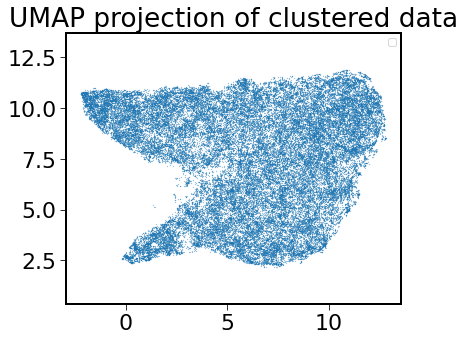

In [107]:
plt.figure().set_figwidth(20)
plt.figure().set_figheight(5)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], s = 0.03)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of clustered data')
plt.legend(prop={'size': 10})
plt.show()

In [14]:
#for m in np.unique(clusters):
#    i=1
#    group = []
#    group_2 = []
#    non_group_indices = []
#    while i <len(clusters)+1:
#            if clusters[i-1] == m:
#                if embedding[i-1][0] < 5:
#                    index_ssospectra = (i*16)-1
#                    mp_number = ssospectra.number_mp[index_ssospectra]
#                    group.append(mp_number)
#                    i+=1
#                else:
#                    index_ssospectra = (i*16)-1
#                    mp_number = ssospectra.number_mp[index_ssospectra]
#                    group_2.append(mp_number)
#                    i+=1
#            else:
#                index_ssospectra = (i*16)-1
#                non_group_indices.append(i)
#                i+=1
#
#    if len(group) > 0:
#        fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#        gs = GridSpec(2, 2, figure=fig)
#        axspectra = []
#        axspectra.append(fig.add_subplot(gs[0, 0]))
#        for axx in axspectra:
#            apply_tufte(axx)
#
#        plt.rcParams.update({'font.size': 22})
#        plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100, 1000])
#        plt.title(f'Group {m} with {len(group)} spectra 2D UMAP x less than 5')
#
#
#    if len(group_2) > 0:
#        fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#        gs = GridSpec(2, 2, figure=fig)
#        axspectra = []
#        axspectra.append(fig.add_subplot(gs[0, 0]))
#        for axx in axspectra:
#            apply_tufte(axx)
#
#        plt.rcParams.update({'font.size': 22})
#        plot_spectra_collection(ssospectra, axspectra[0], fig, group_2, cbarticks=[10, 50, 100, 1000])
#        plt.title(f'Group {m} with {len(group_2)} spectra 2D UMAP x greater than 5')
#

<ipython-input-93-287c8e8aaa56>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)


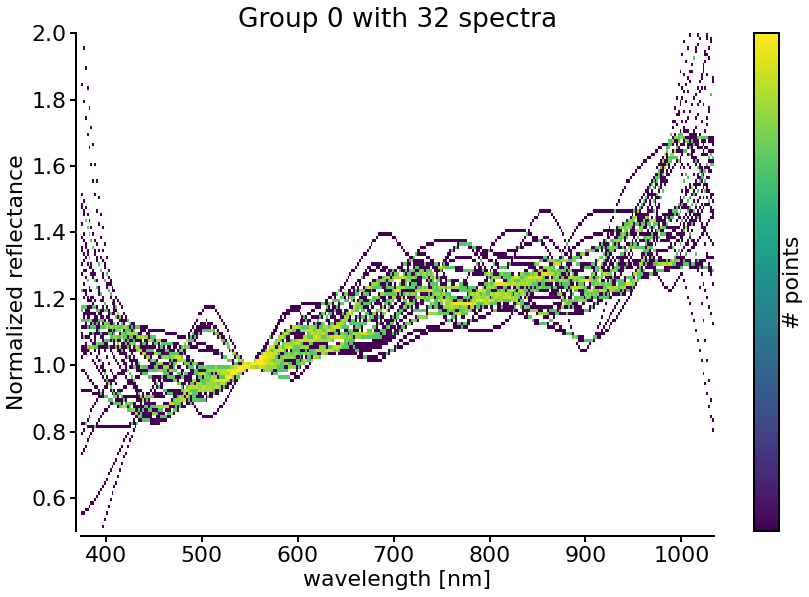

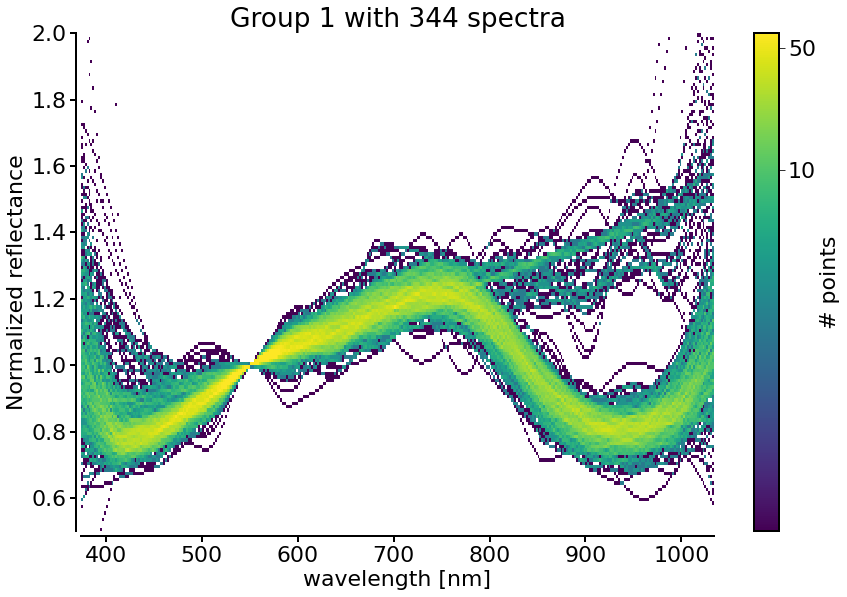

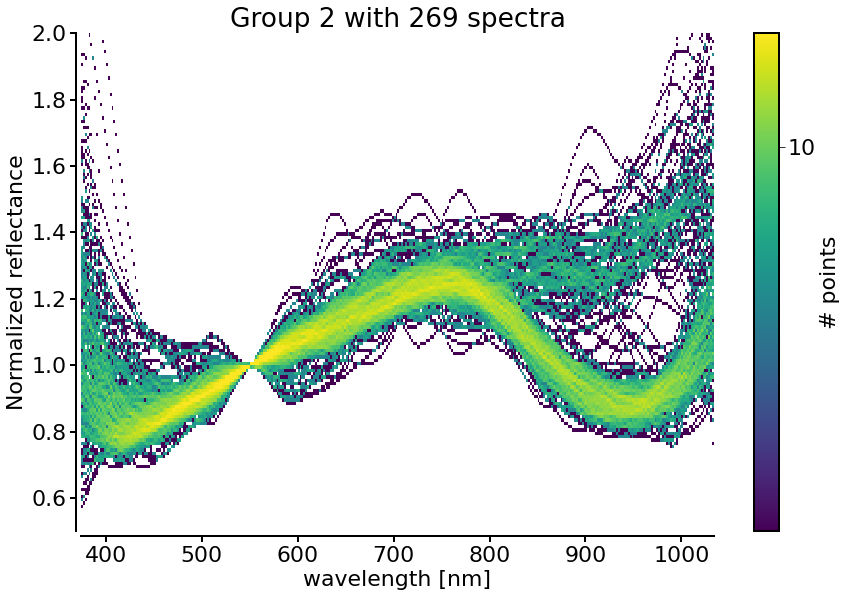

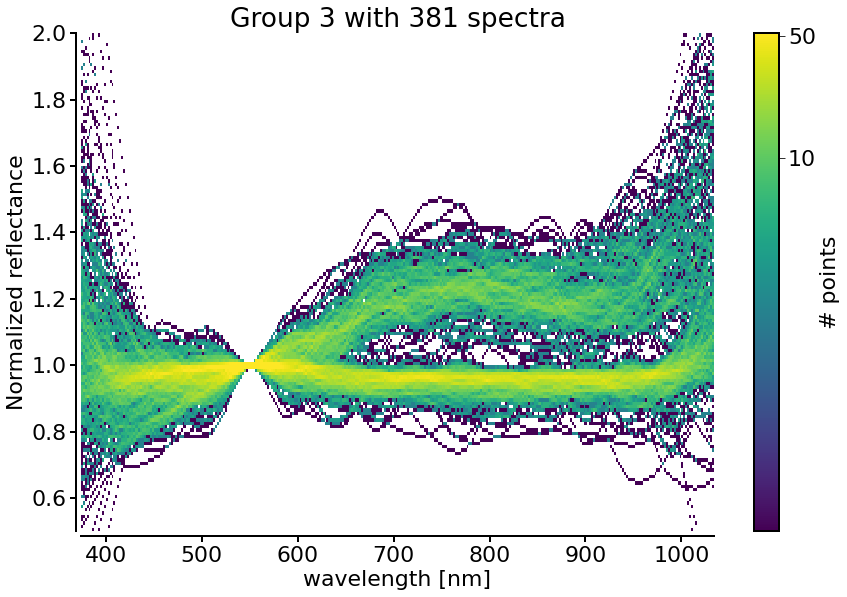

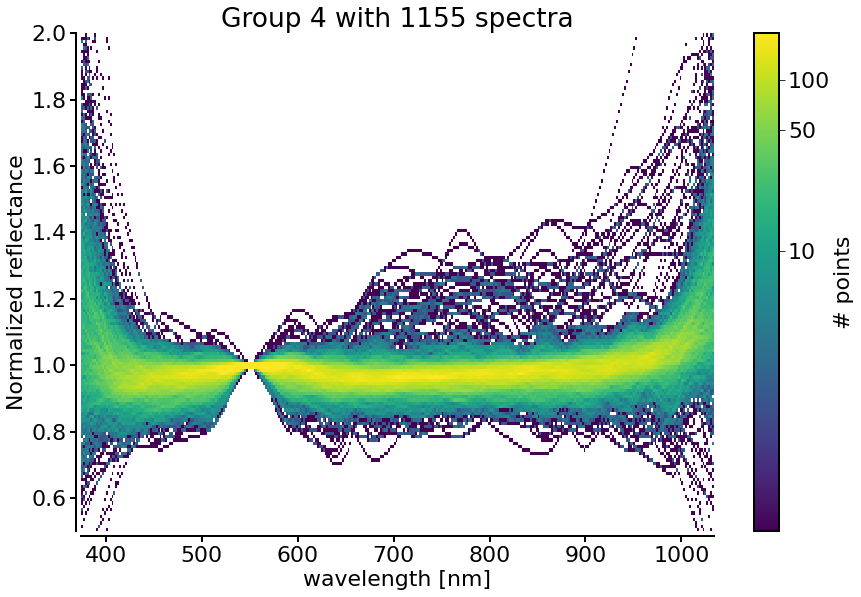

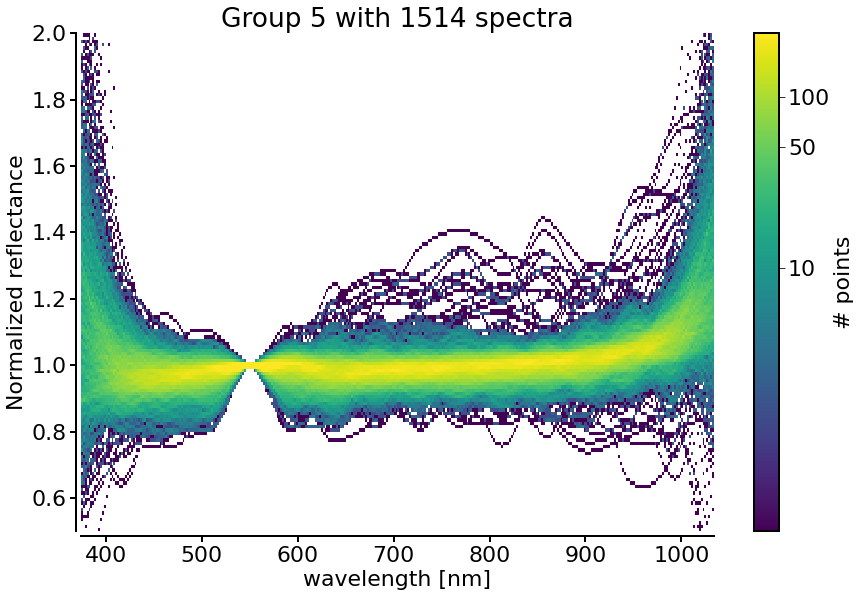

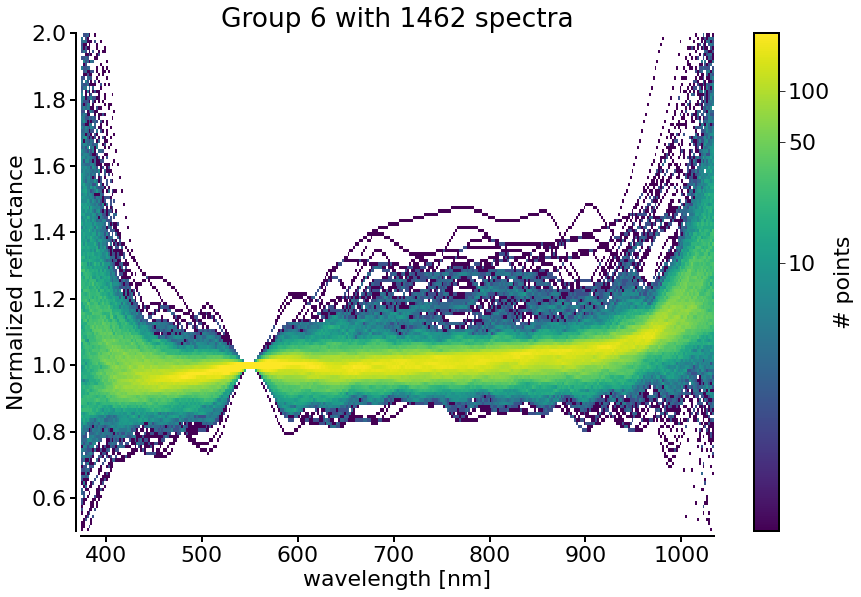

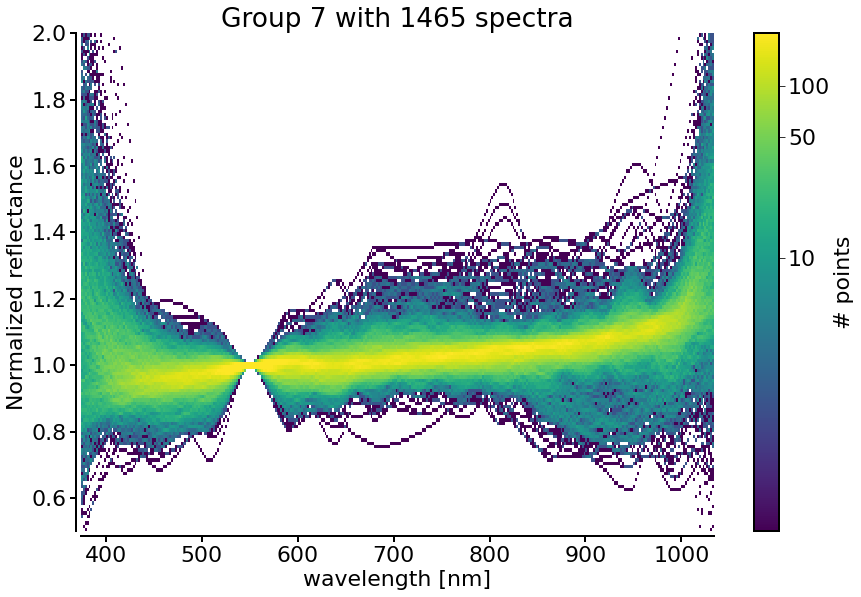

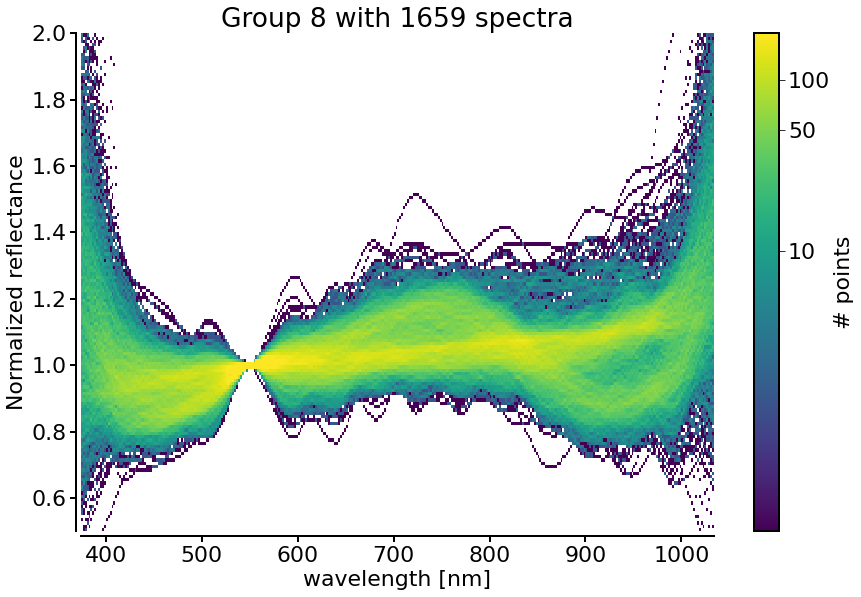

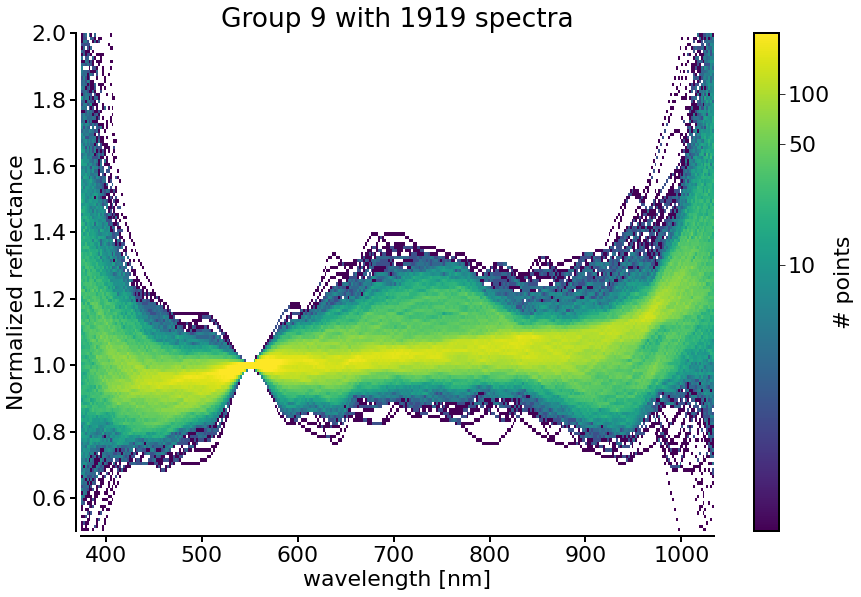

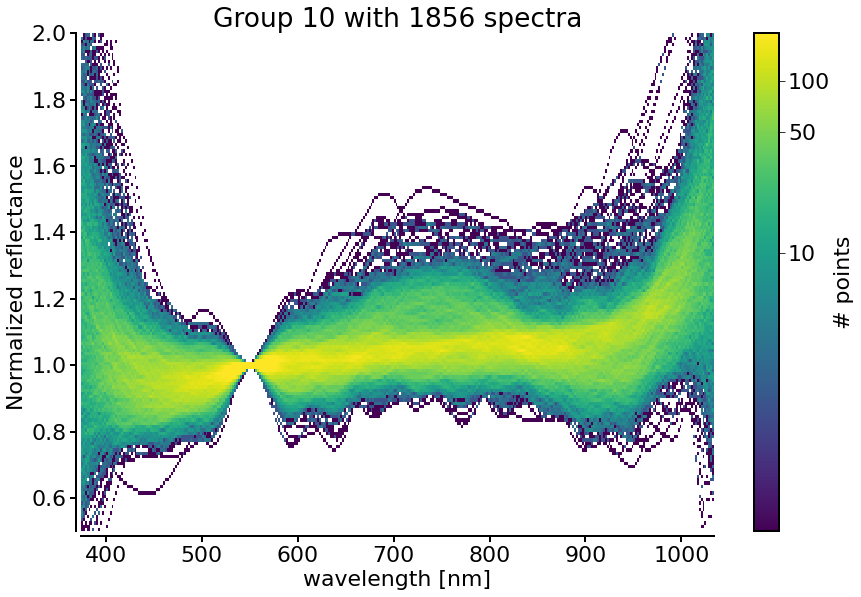

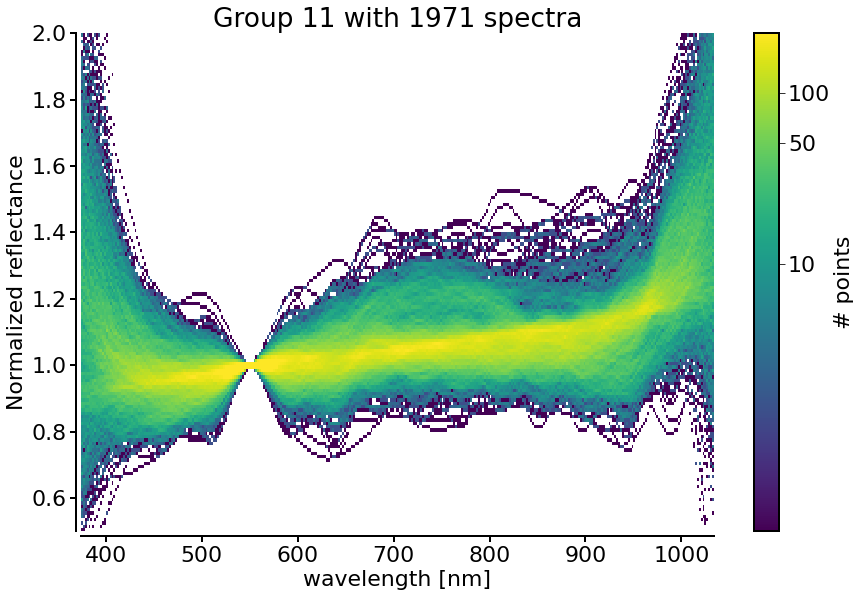

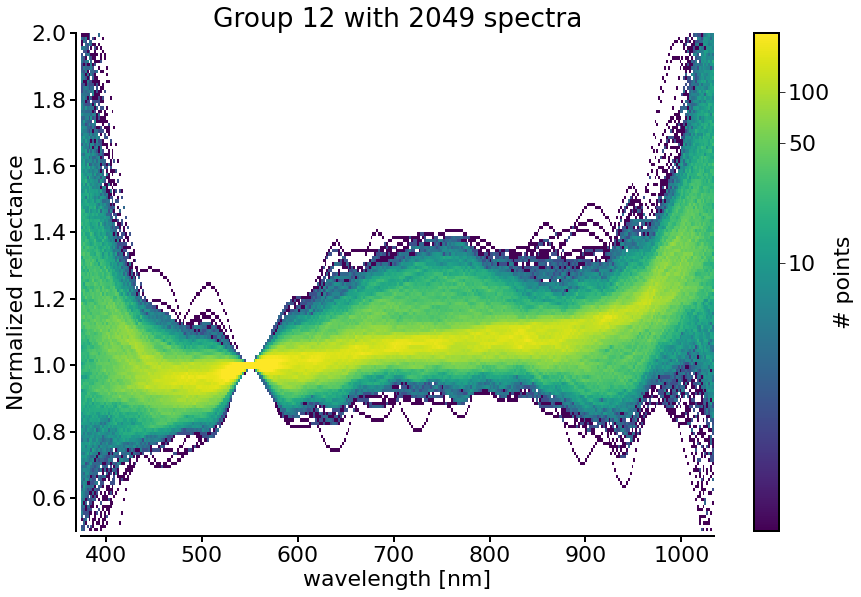

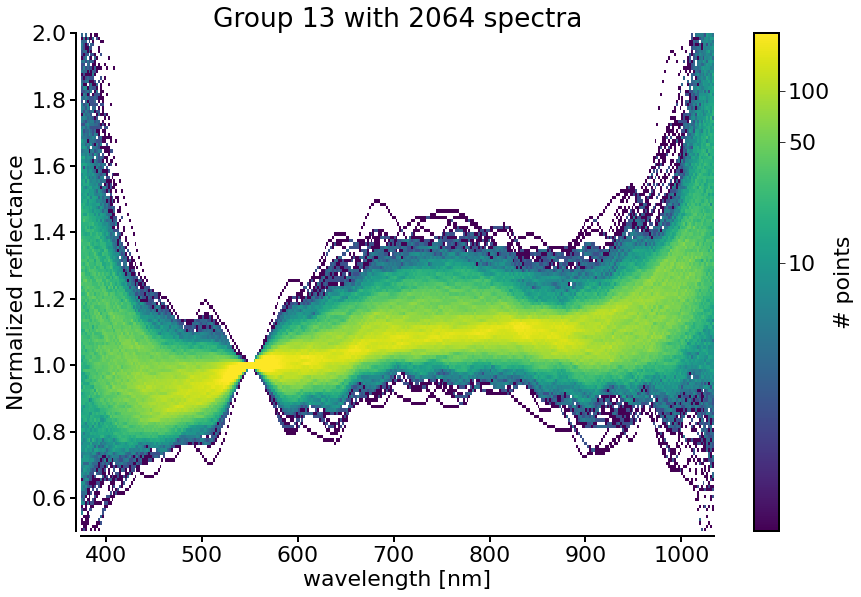

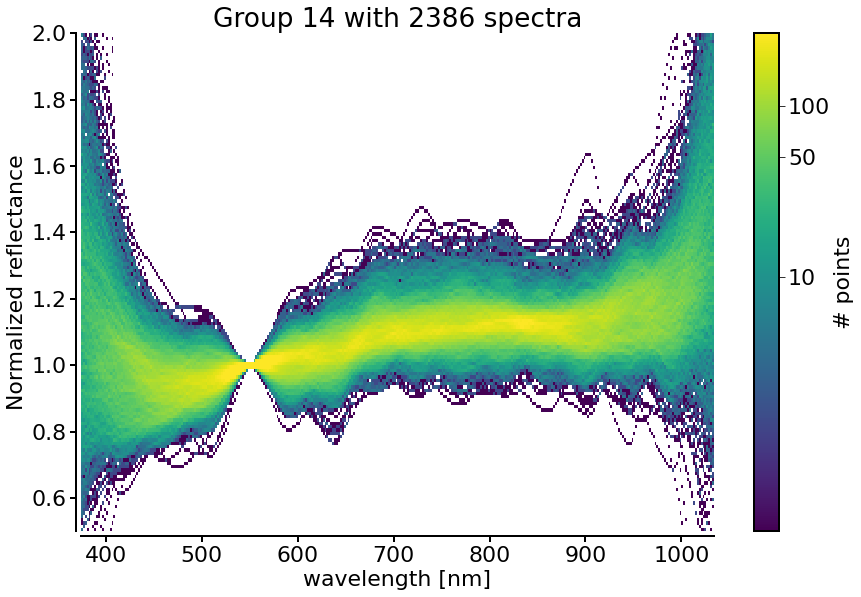

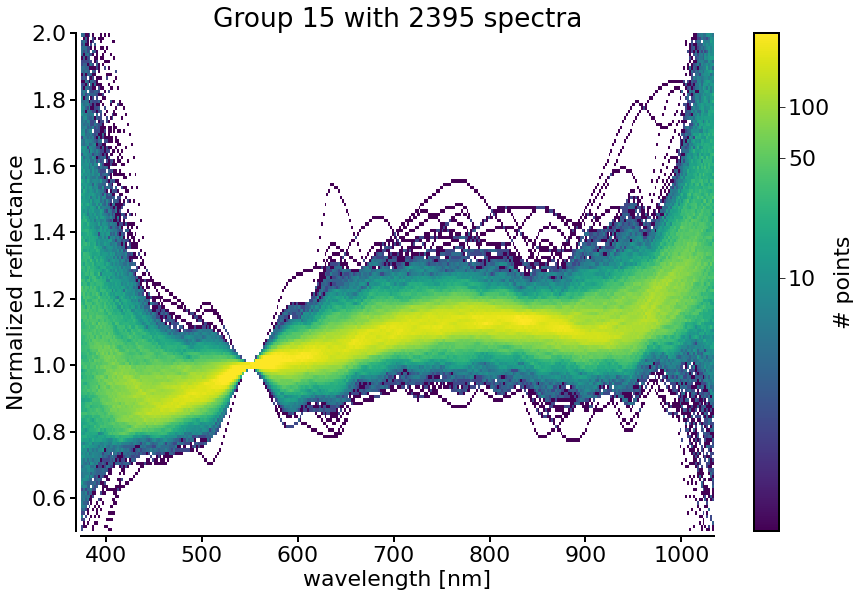

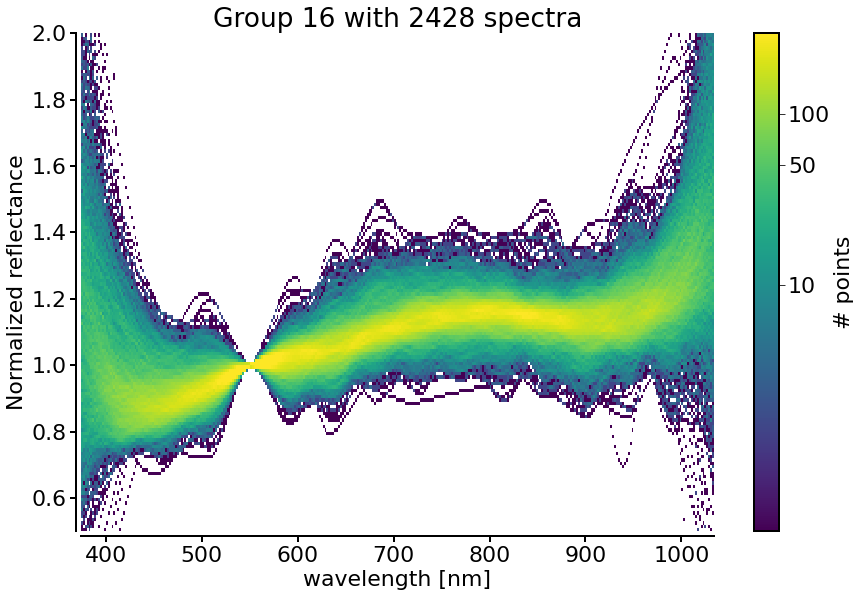

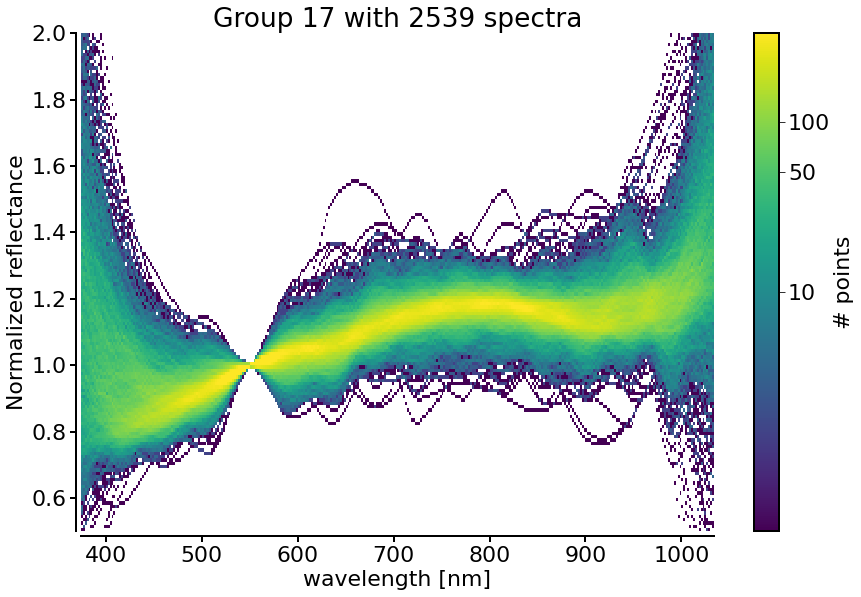

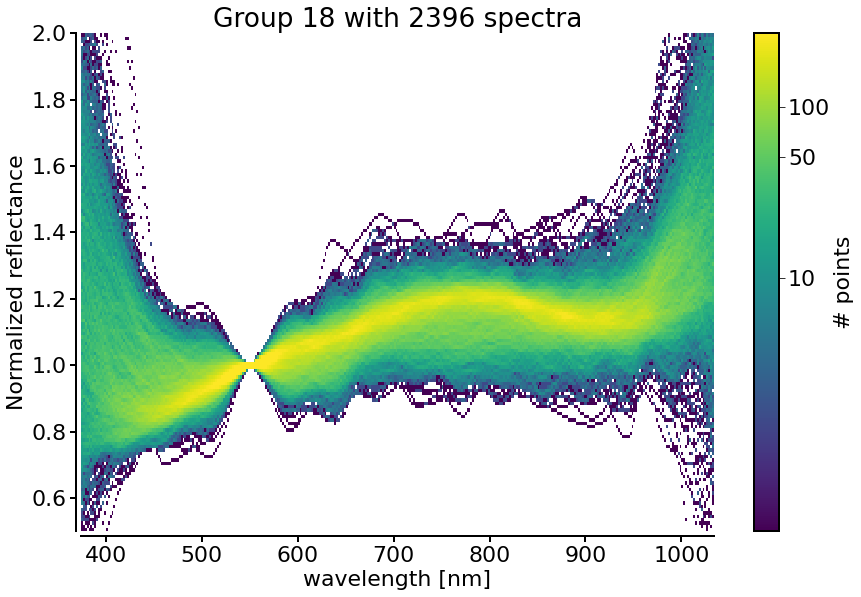

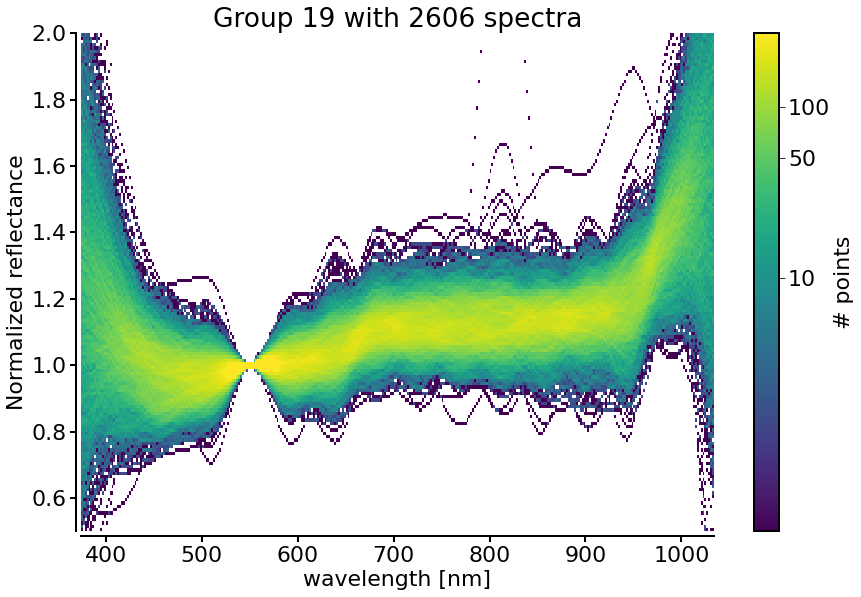

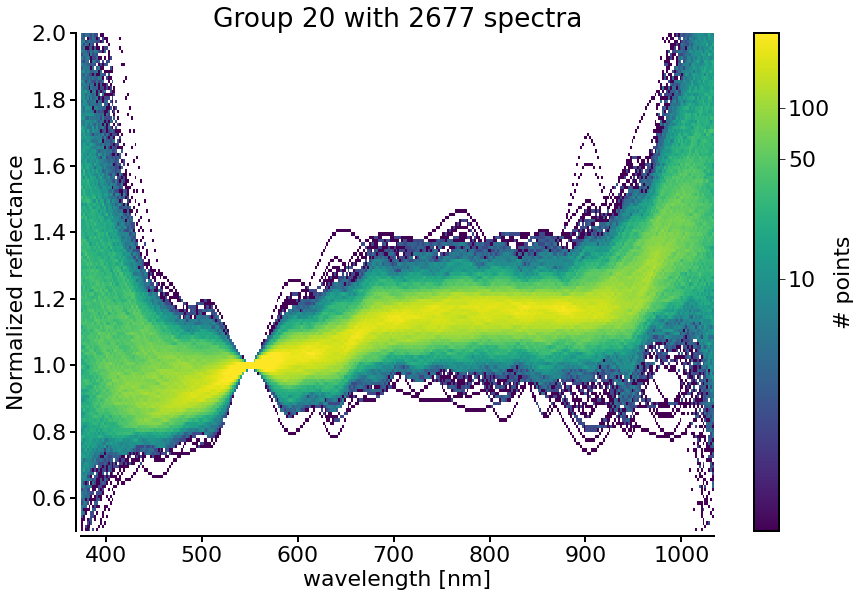

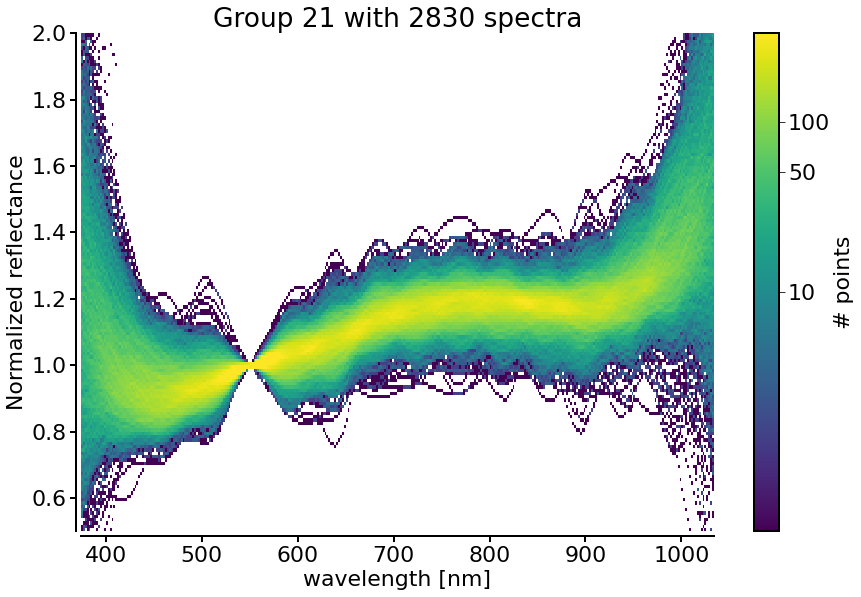

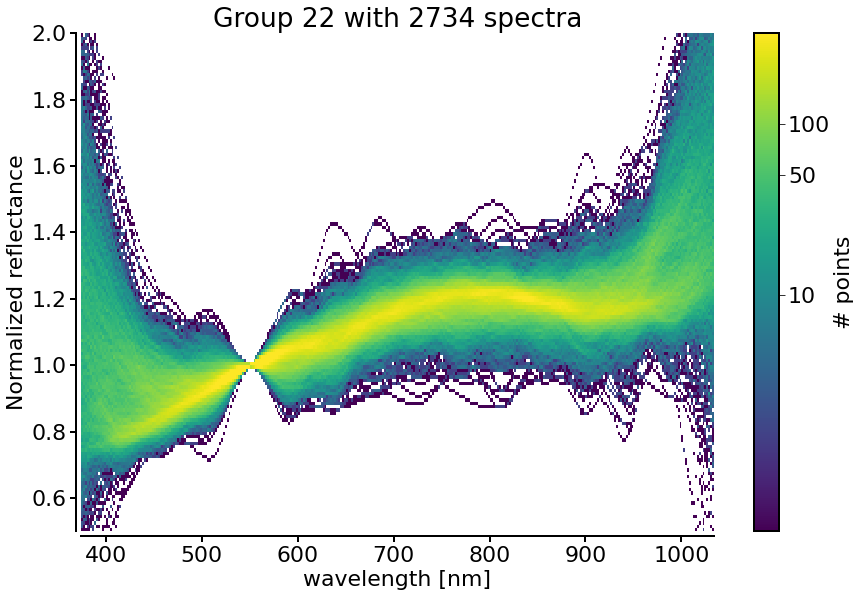

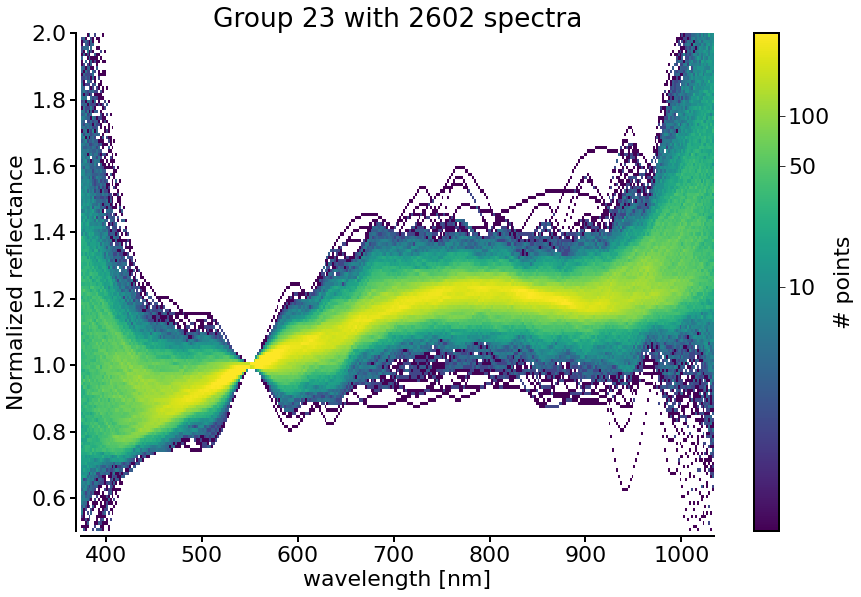

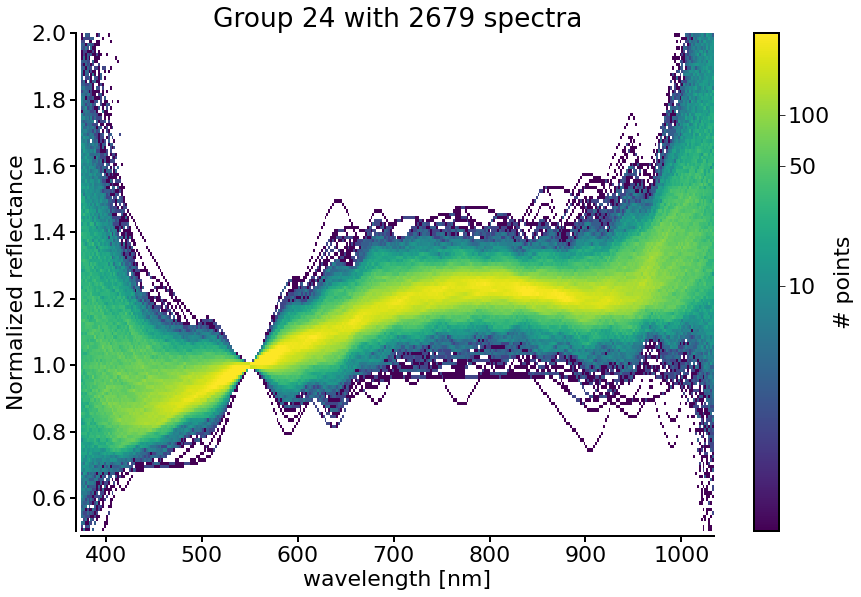

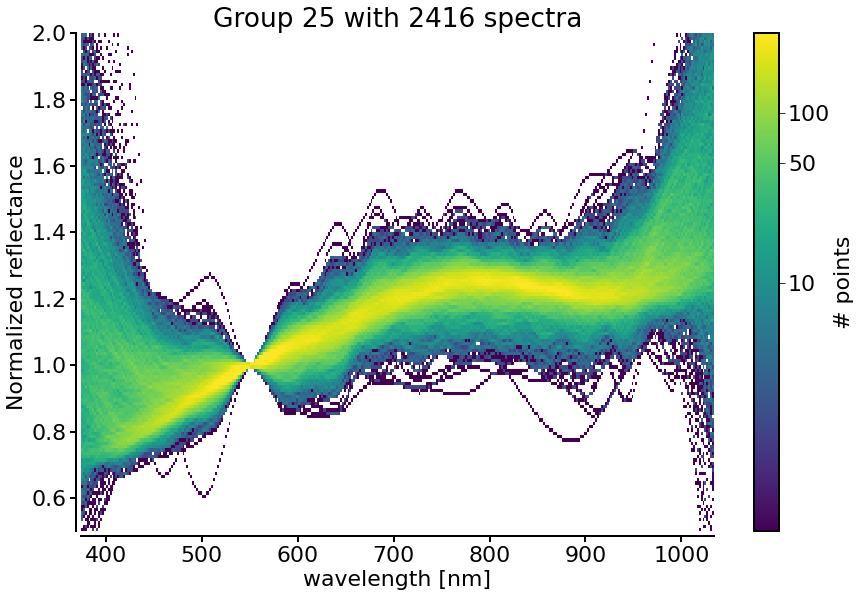

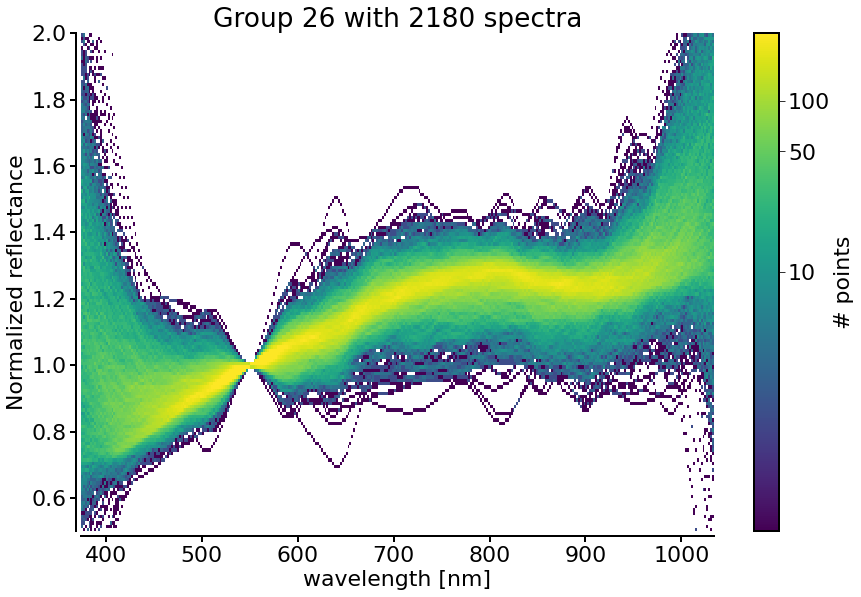

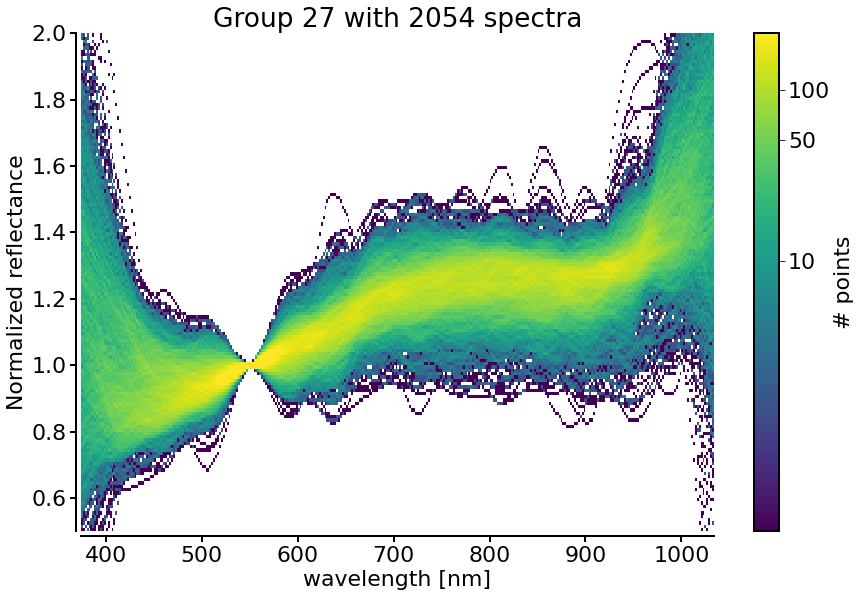

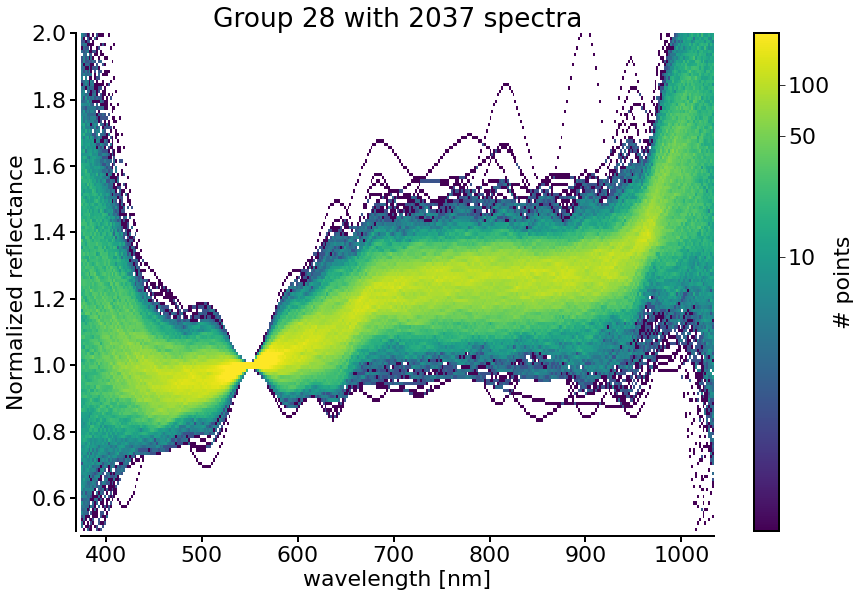

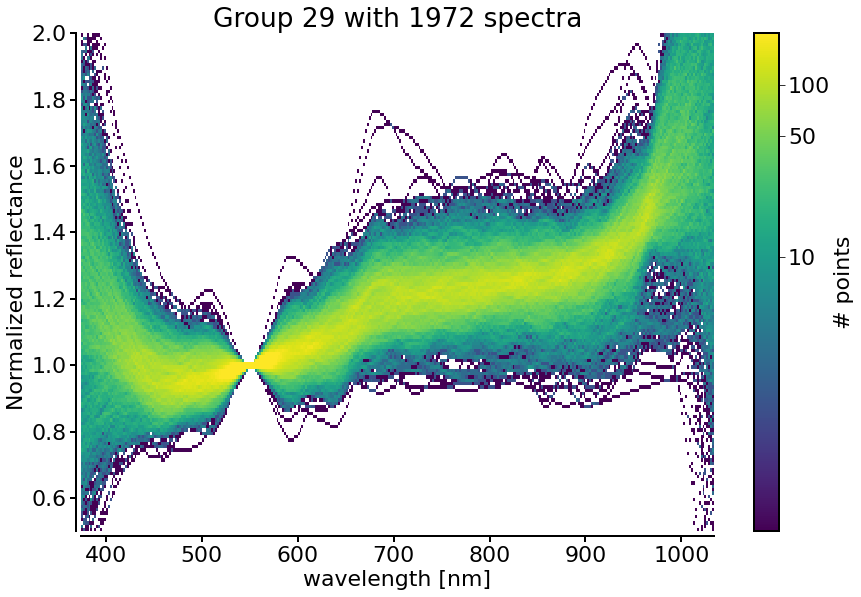

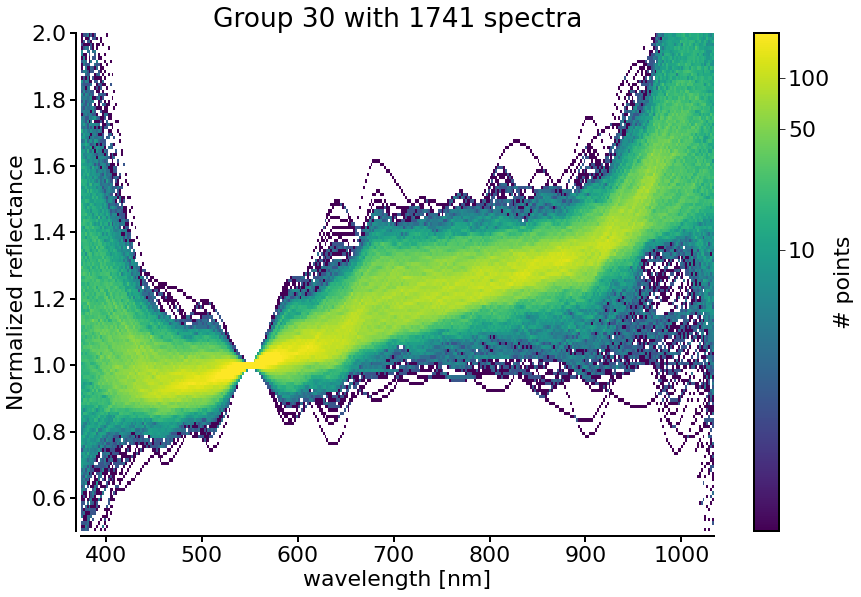

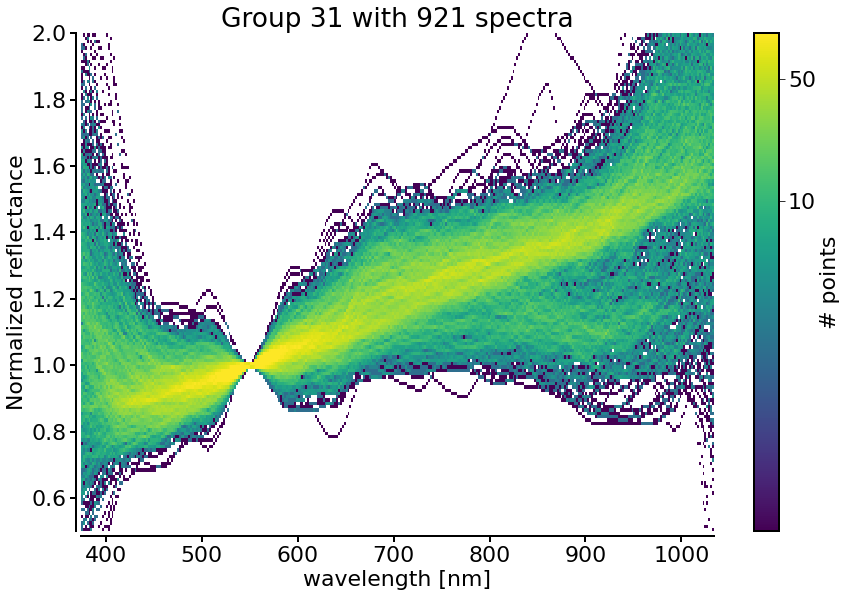

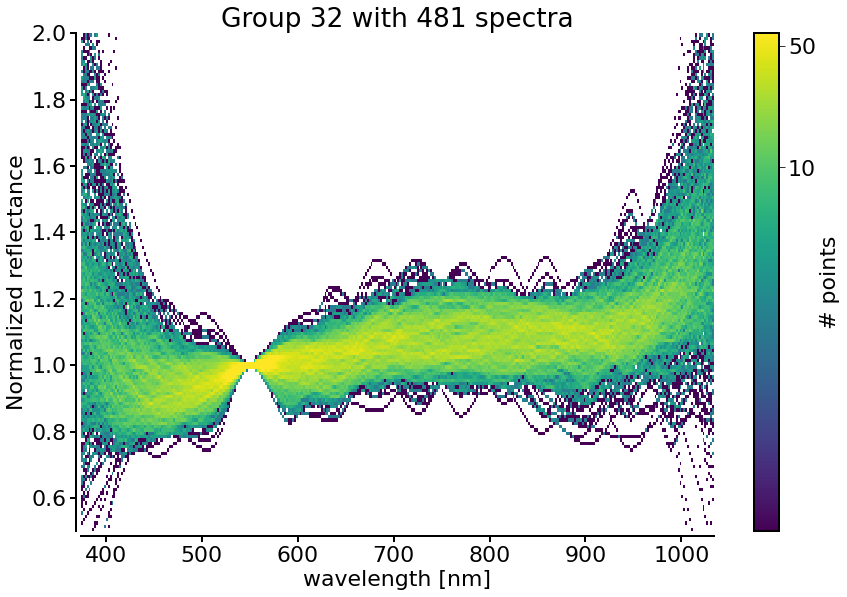

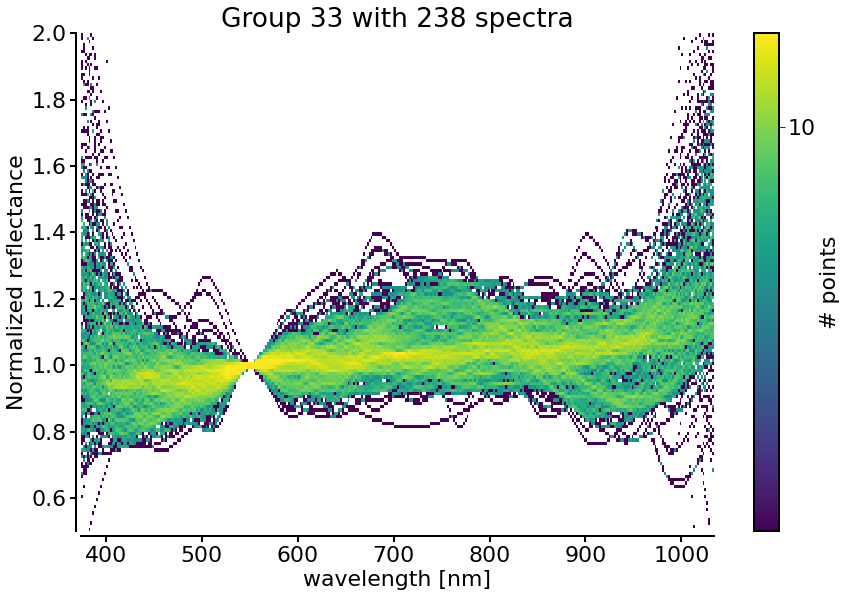

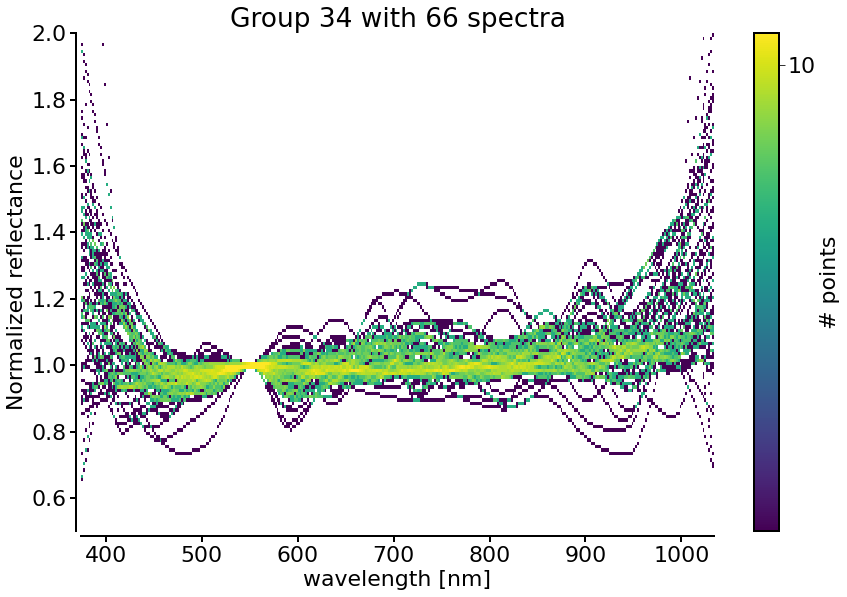

In [93]:
#unique_labels = np.unique(clusters)
#for n in unique_labels:
#    i=1
#    group = []
#    non_group_indices = []
#    while i <len(clusters)+1:
#            if clusters[i-1] == 
#                index_ssospectra = (i*16)-1
#                mp_number = ssospectra.number_mp[index_ssospectra]
#                group.append(mp_number)
#                i+=1
#            else:
#                index_ssospectra = (i*16)-1
#                non_group_indices.append(i)
#                i+=1
#
#
#
#    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#    gs = GridSpec(2, 2, figure=fig)
#    axspectra = []
#    axspectra.append(fig.add_subplot(gs[0, 0]))
#    for axx in axspectra:
#        apply_tufte(axx)
#
#    plt.rcParams.update({'font.size': 22})
#    plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100, 1000])
#    plt.title(f'Group {int(n)} with {len(group)} spectra')

In [ ]:
np.unique(clusters)[0:13]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

### Plot all spectra of clusters UMAP 1D one by one 

In [1]:
#unique_labels = np.unique(clusters)
#for n in unique_labels:
#    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
#    gs = GridSpec(2, 2, figure=fig)
#    axspectra = []
#    axspectra.append(fig.add_subplot(gs[0, 0]))
#    for axx in axspectra:
#        apply_tufte(axx)
#
#    plt.rcParams.update({'font.size': 22})
#    plot_spectra_collection(ssospectra, axspectra[0], fig, MP3C['# number'].iloc[clusters == n], cbarticks=[10, 50, 100, 1000])
#    plt.title(f'Group {int(n)} with spectra')

In [10]:
rounded = 10*(np.round(embedding_1D, 1))
min_value = np.min(rounded)
clusters = rounded-min_value

### Plot all spectra of clusters UMAP 1D one by one of increased resolution

<ipython-input-11-9ca5178e4f03>:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)


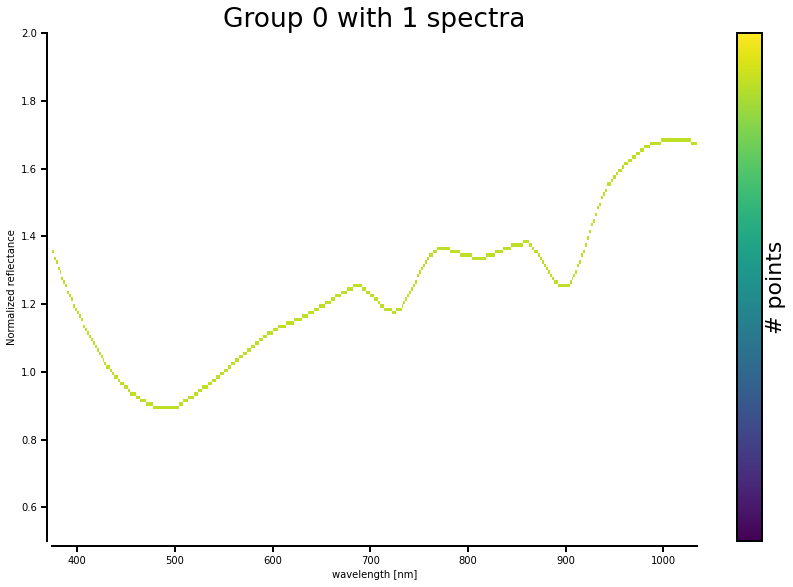

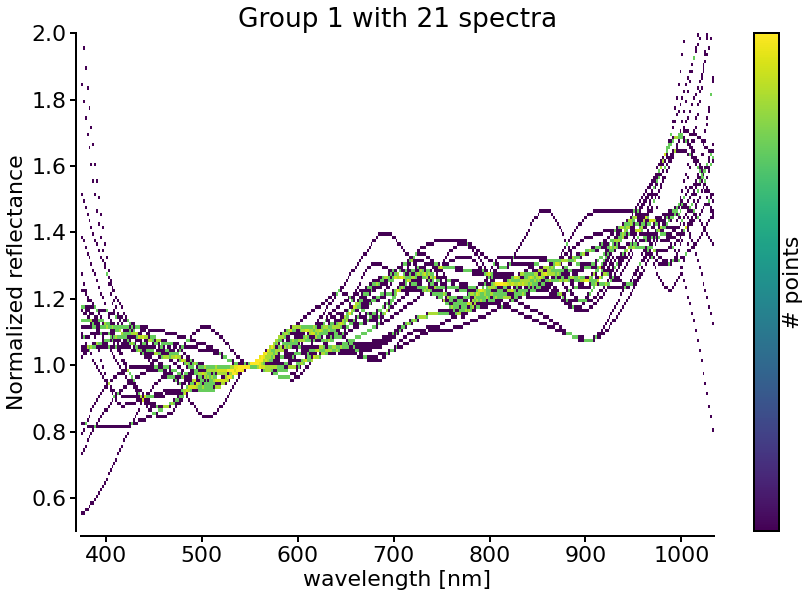

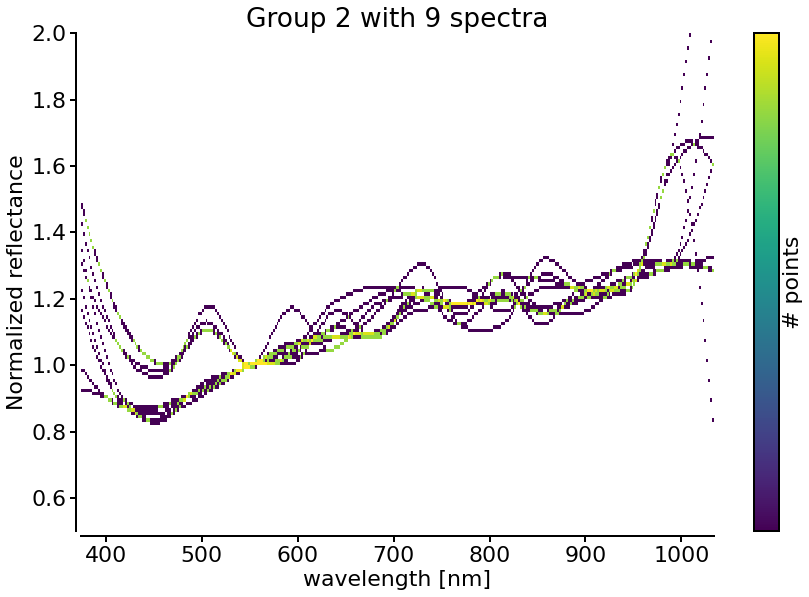

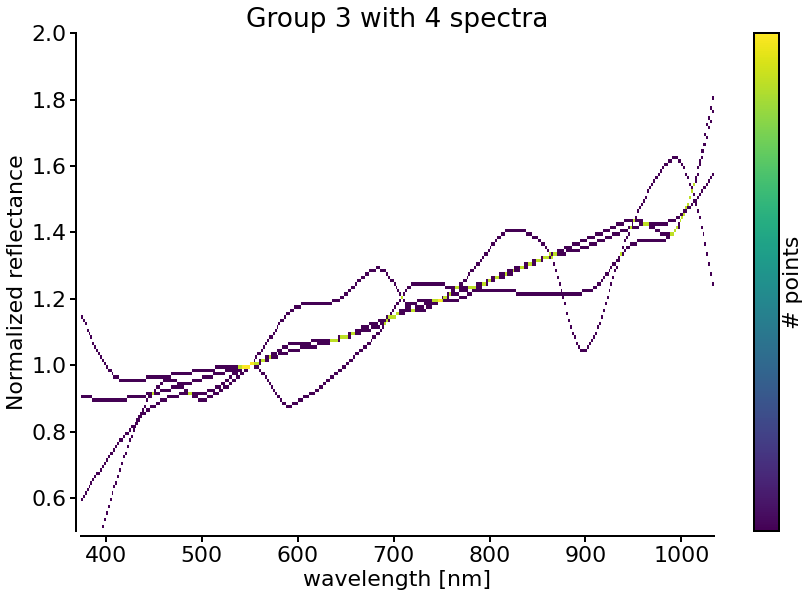

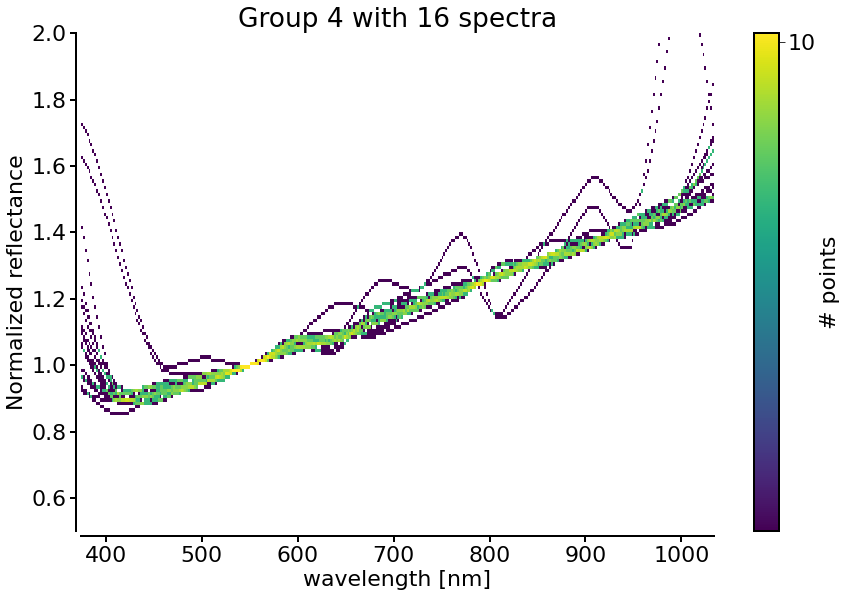

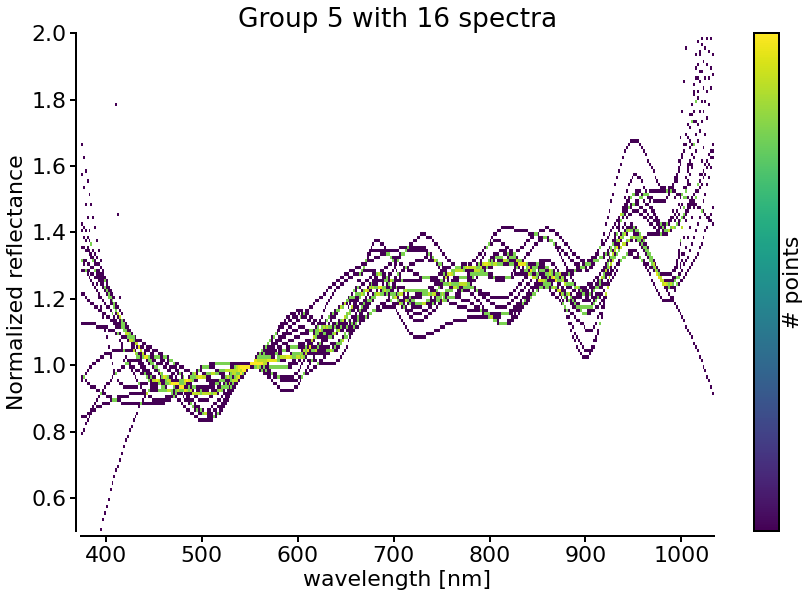

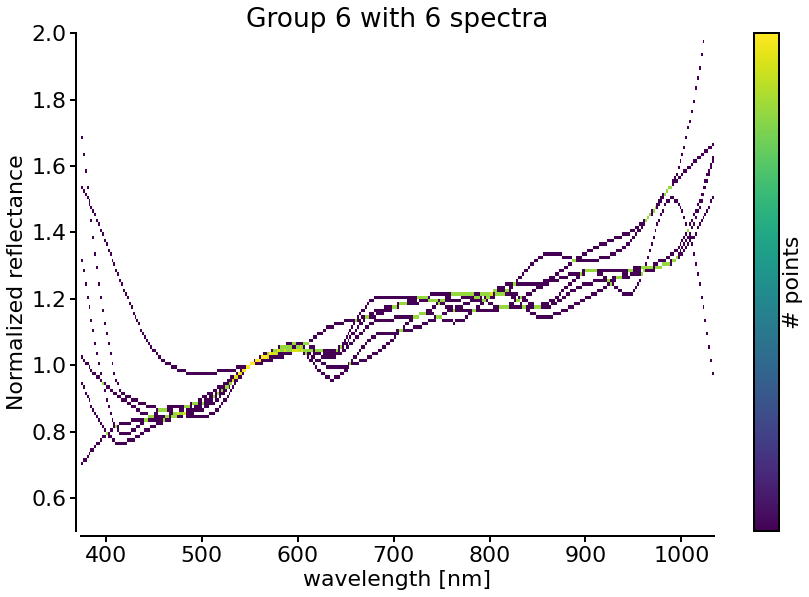

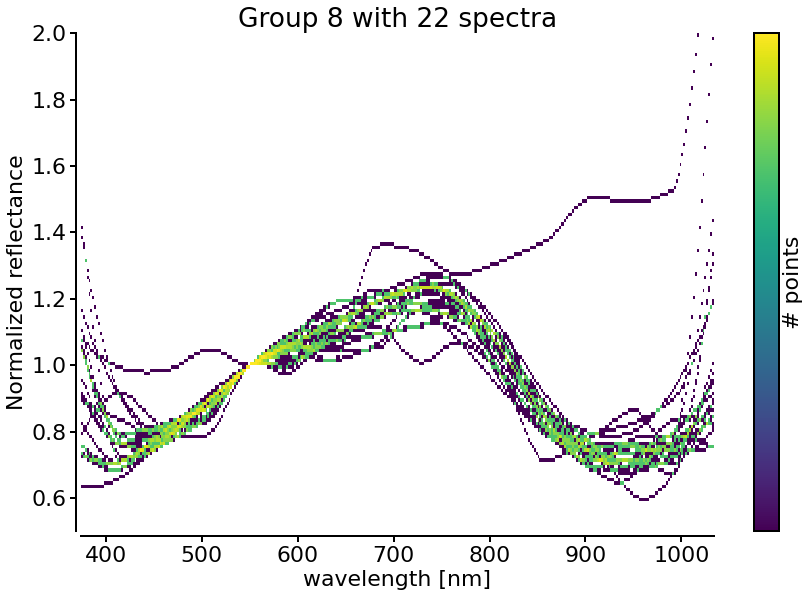

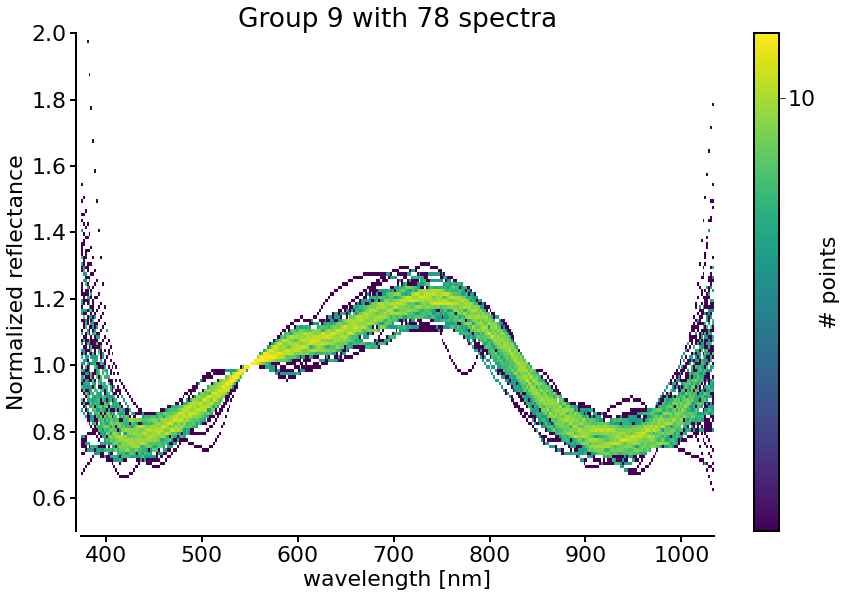

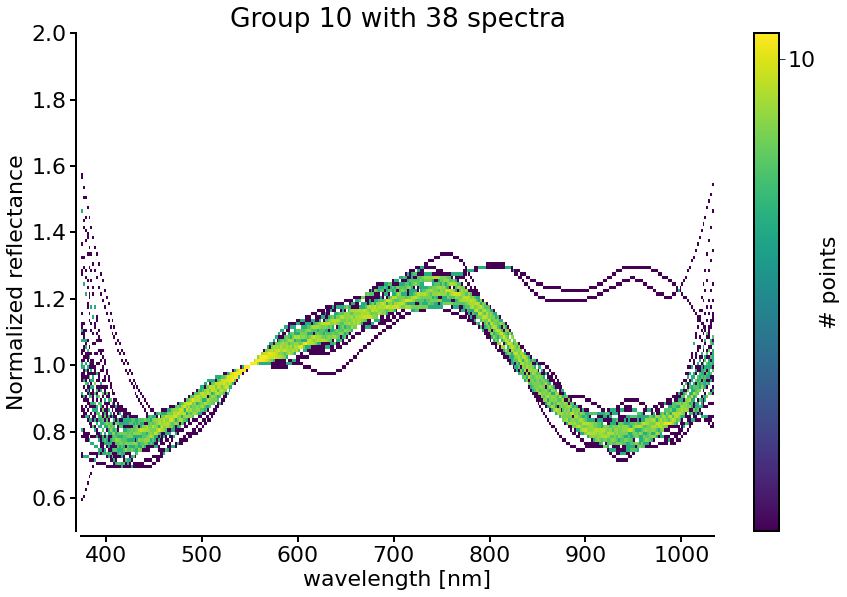

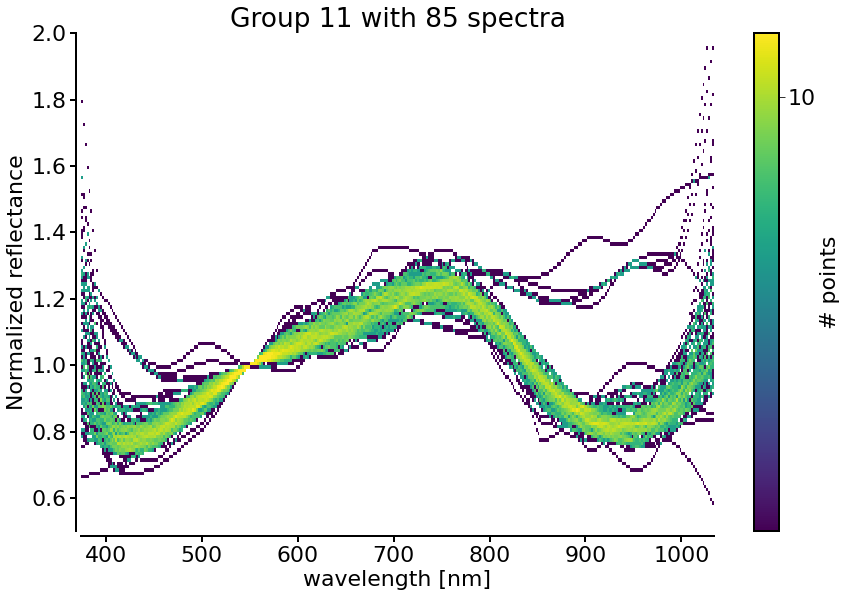

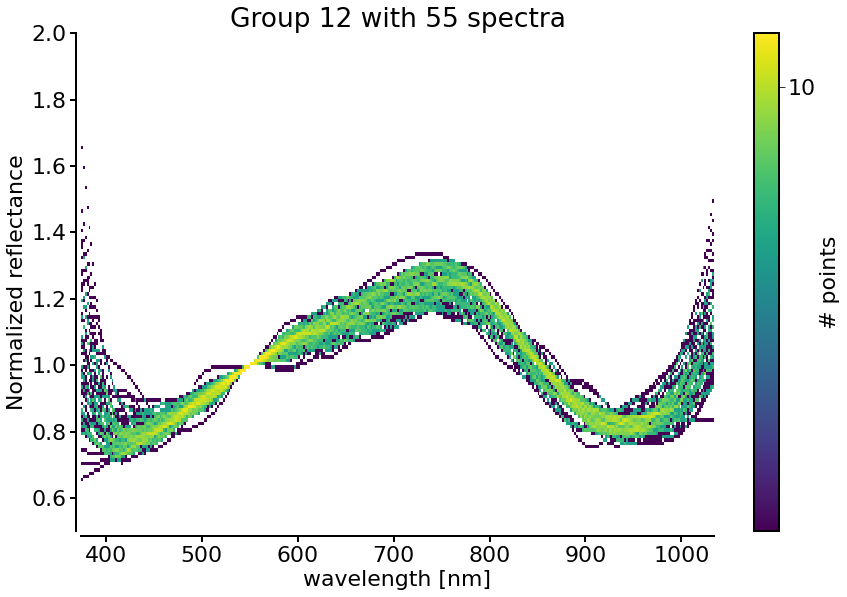

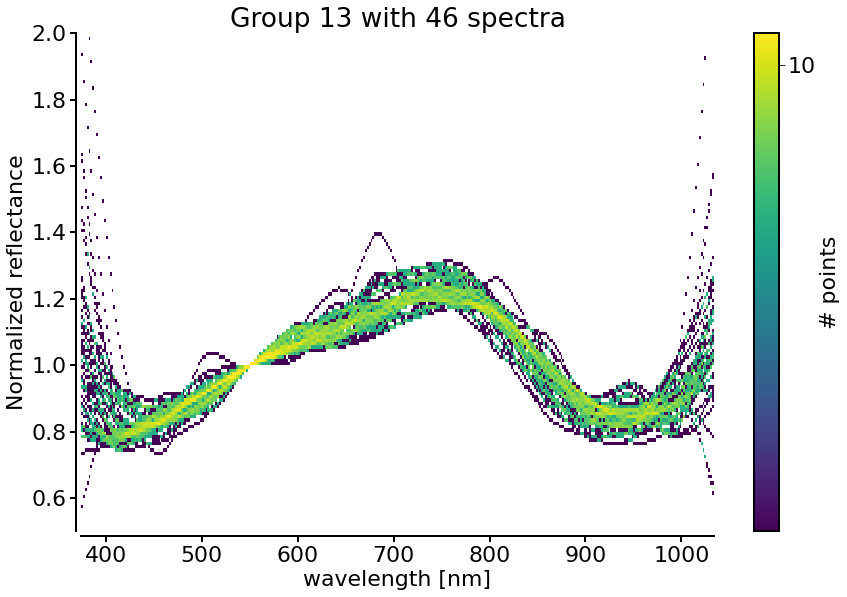

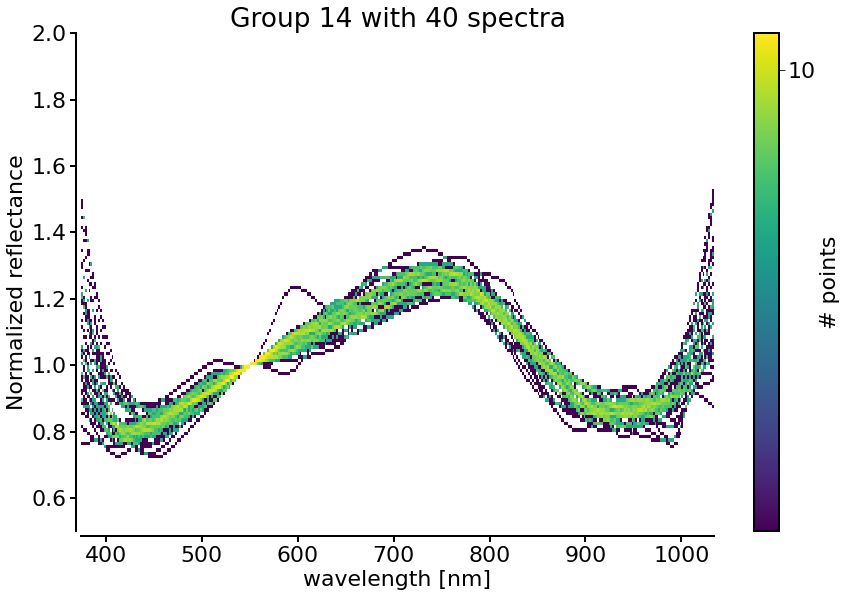

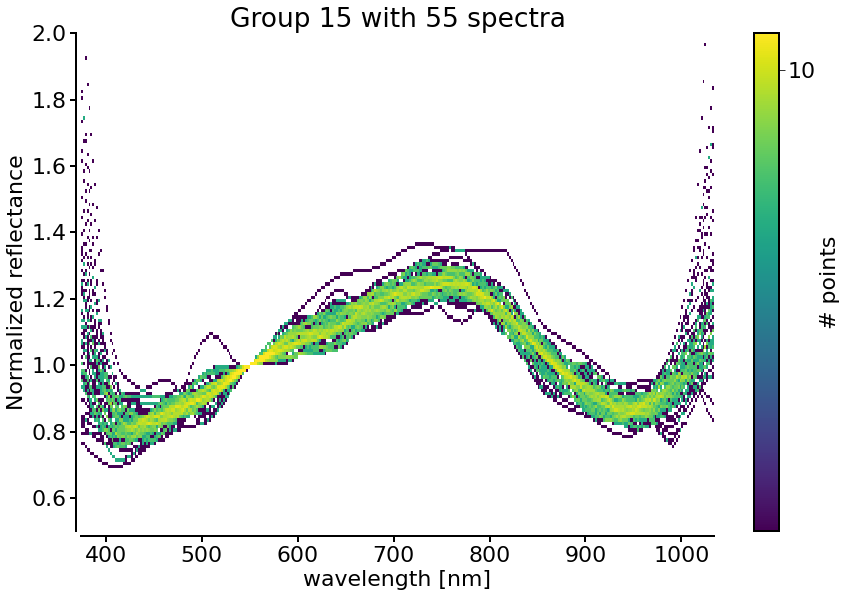

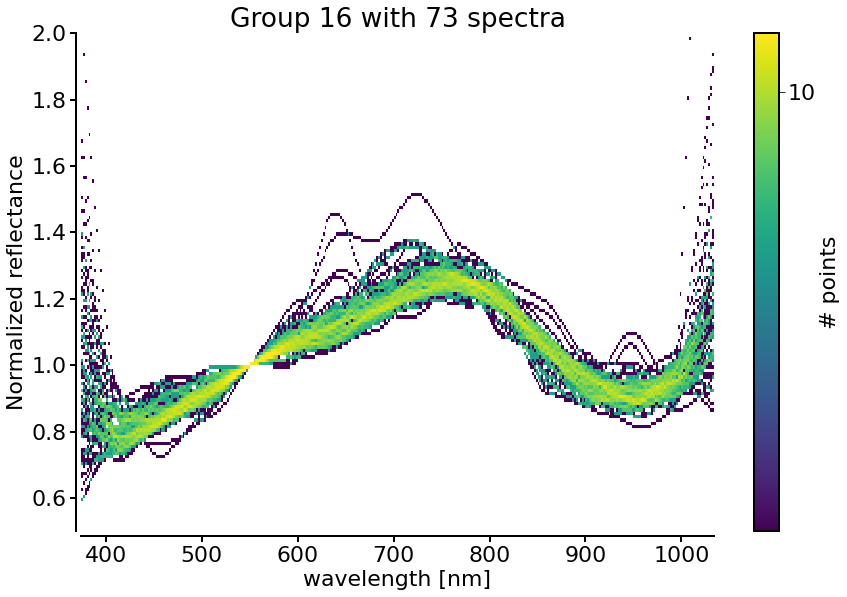

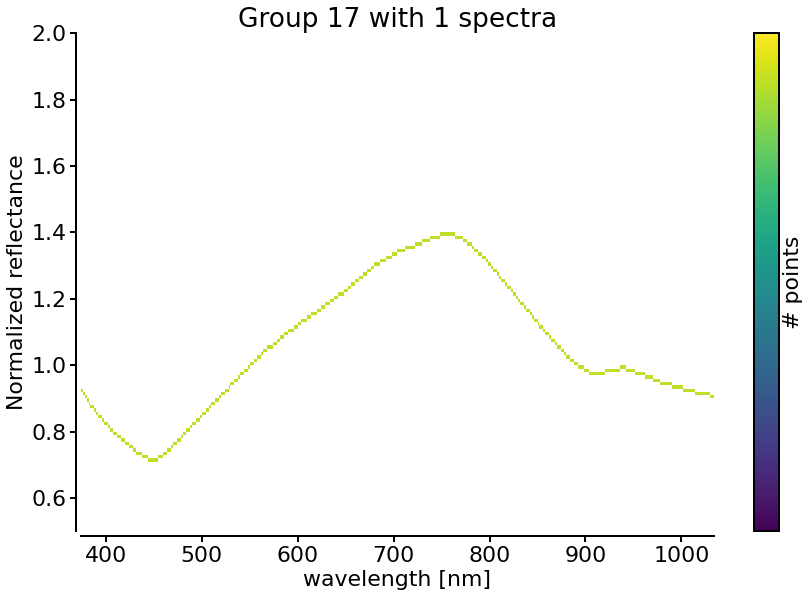

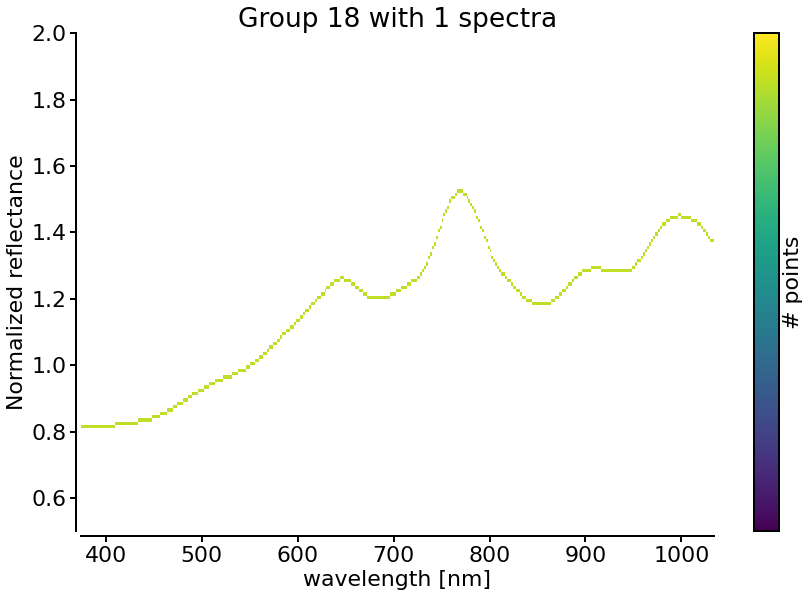

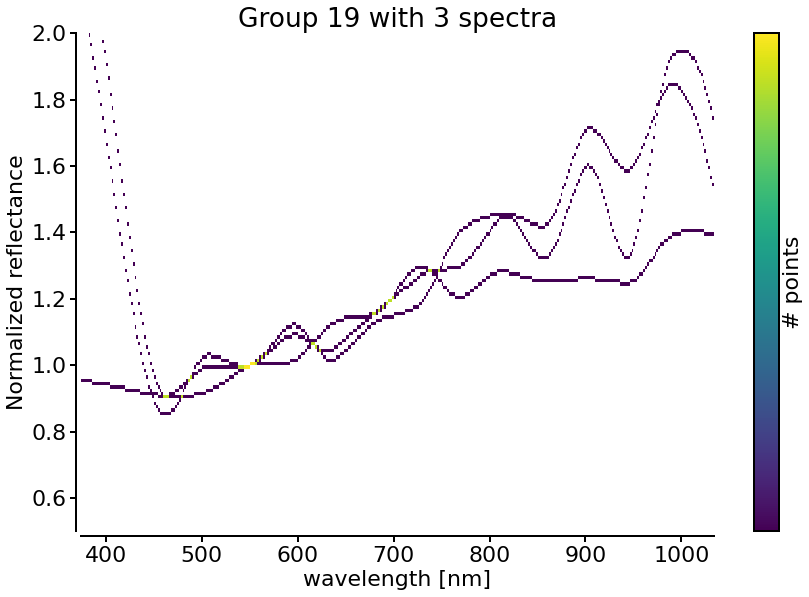

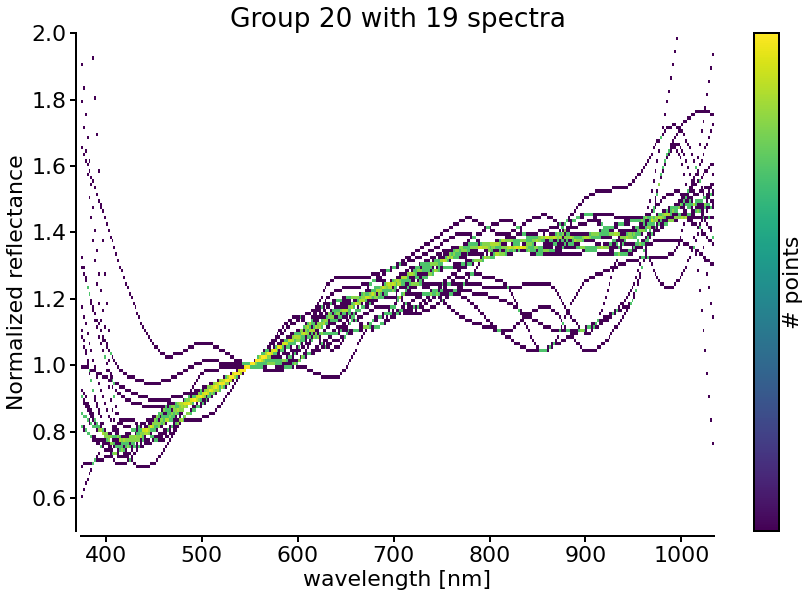

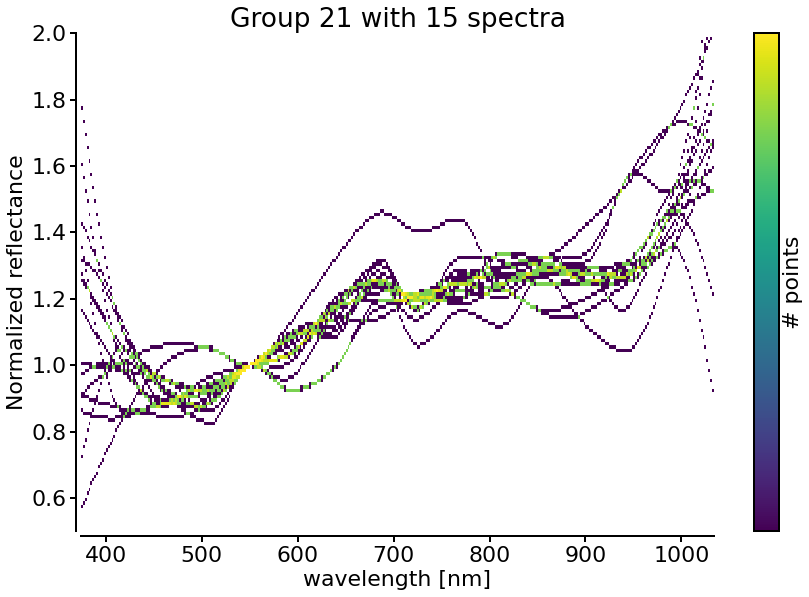

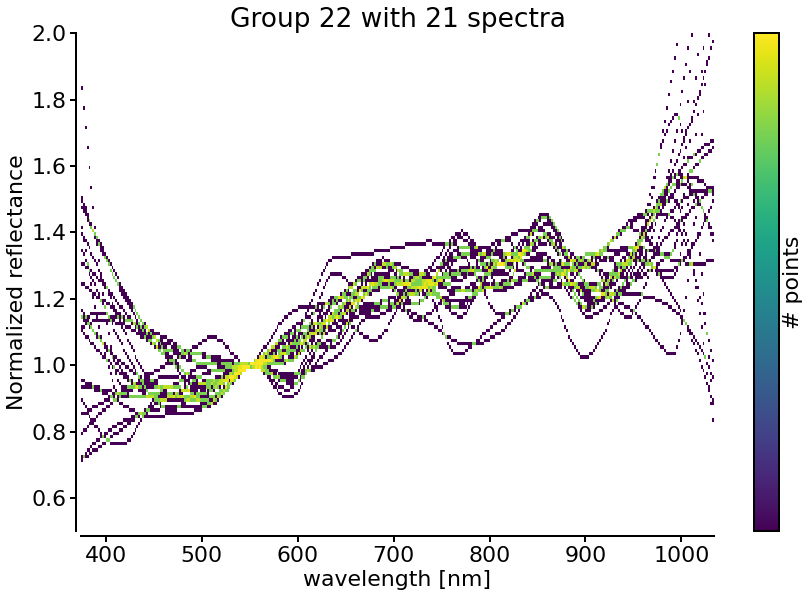

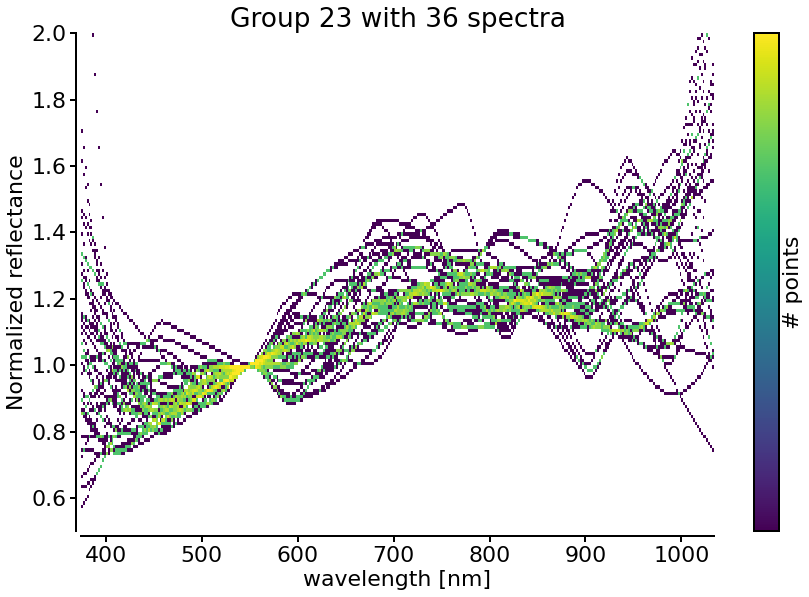

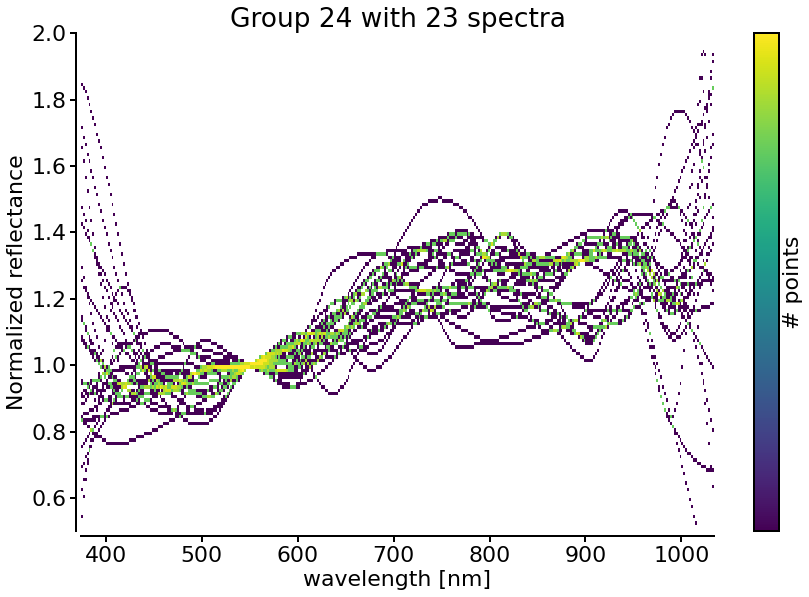

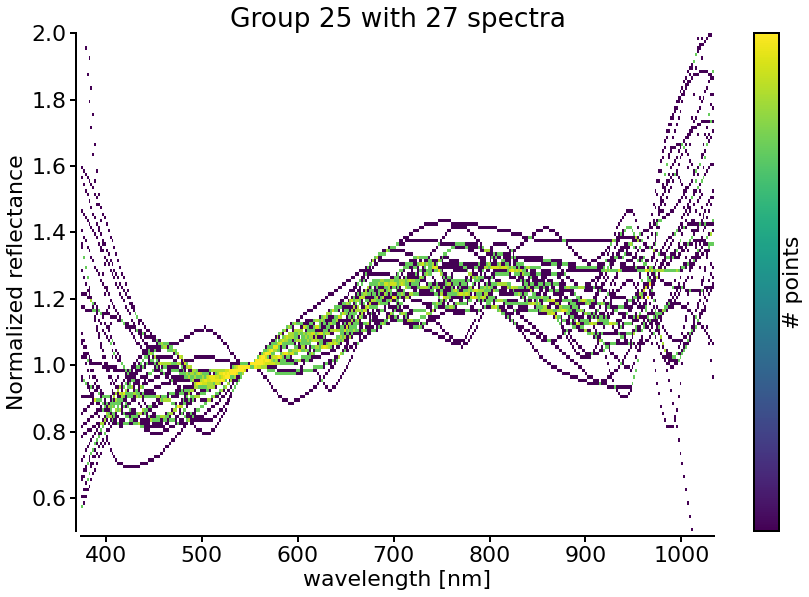

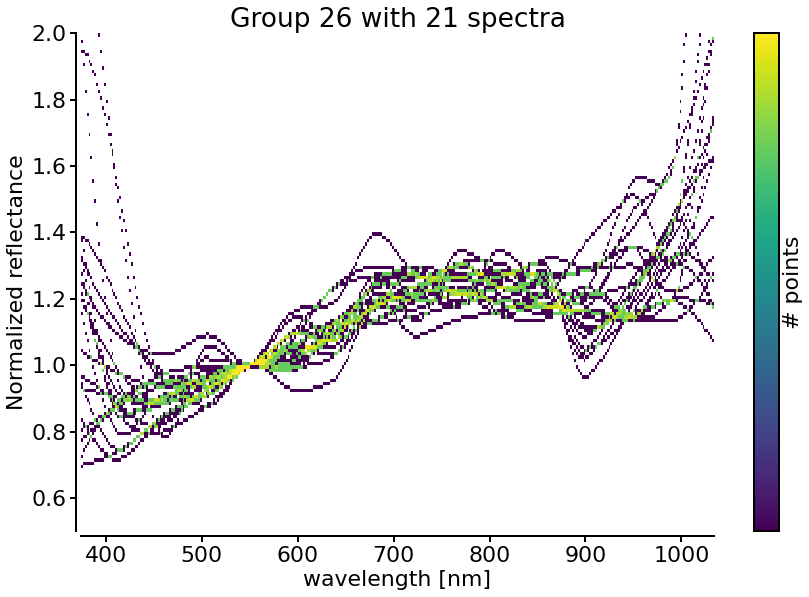

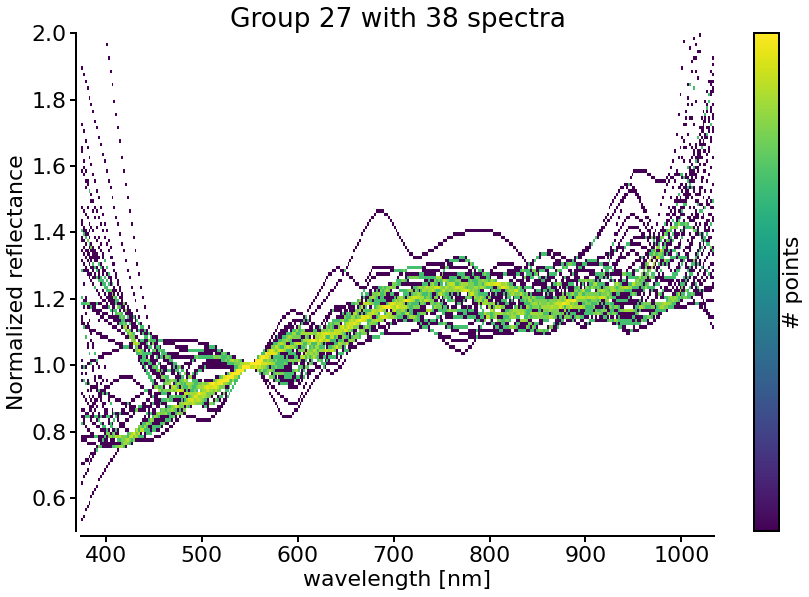

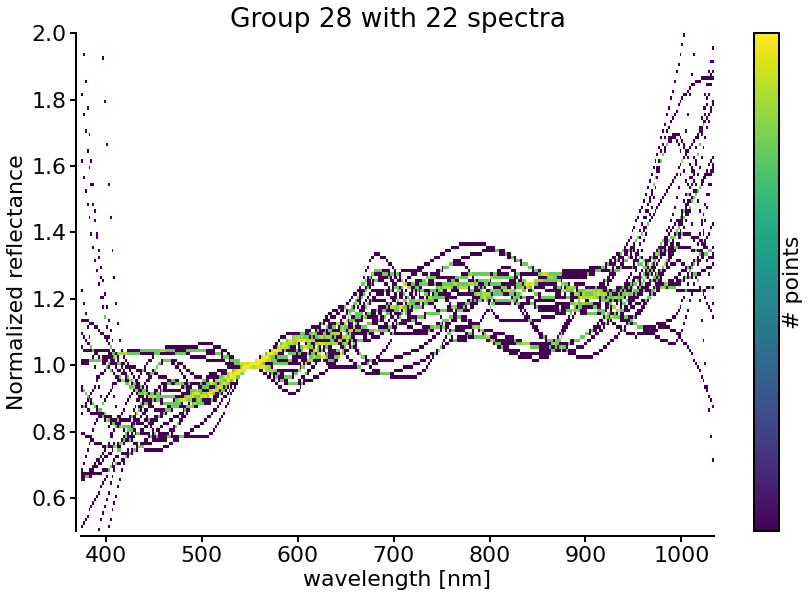

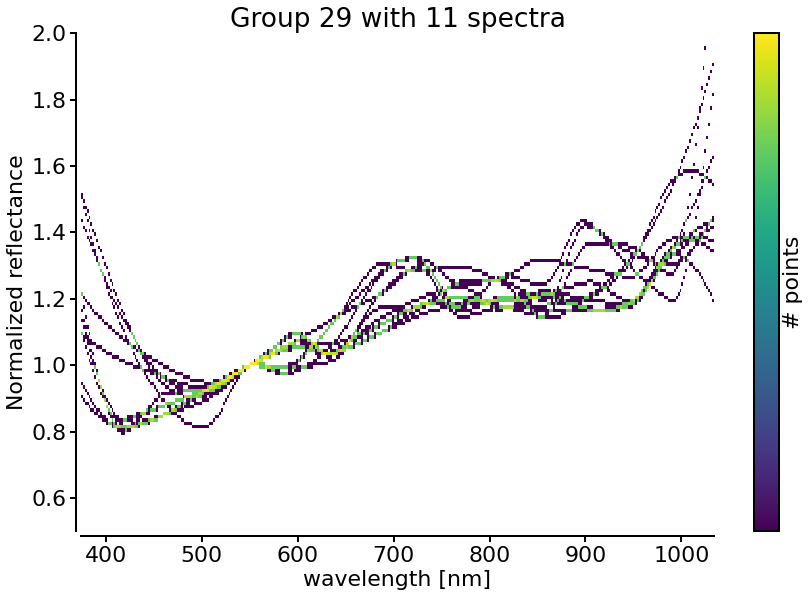

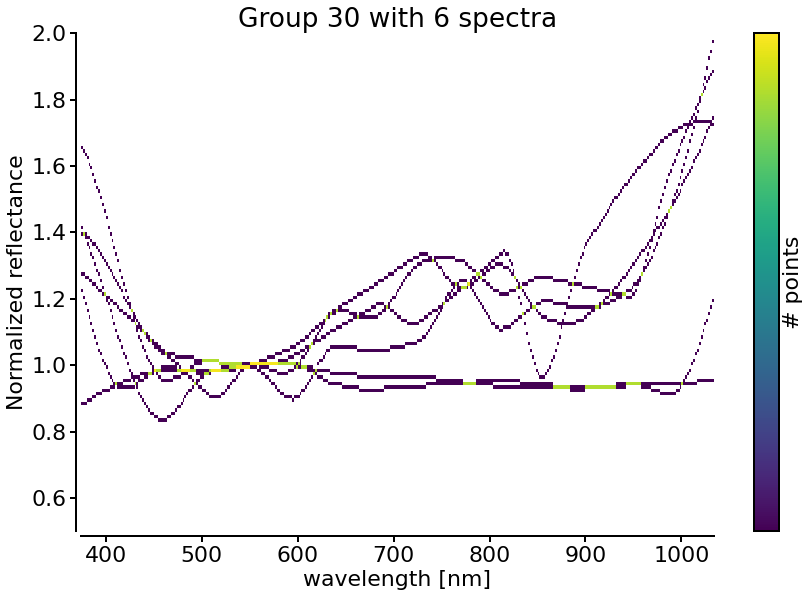

In [11]:
unique_labels = np.unique(clusters)[0:30]
for n in unique_labels:
    i=1
    group = []
    non_group_indices = []
    while i <len(clusters)+1:
            if clusters[i-1] == n:
                index_ssospectra = (i*16)-1
                mp_number = ssospectra.number_mp[index_ssospectra]
                group.append(mp_number)
                i+=1
            else:
                index_ssospectra = (i*16)-1
                non_group_indices.append(i)
                i+=1



    fig = plt.figure(figsize=(2 * 12, 2 * 8), tight_layout=True)
    gs = GridSpec(2, 2, figure=fig)
    axspectra = []
    axspectra.append(fig.add_subplot(gs[0, 0]))
    for axx in axspectra:
        apply_tufte(axx)

    plt.rcParams.update({'font.size': 22})
    plot_spectra_collection(ssospectra, axspectra[0], fig, group, cbarticks=[10, 50, 100, 1000])
    plt.title(f'Group {int(n)} with {len(group)} spectra')